In [164]:
import numpy as np
from matplotlib import pyplot as plt
import glob
# from scipy.stats import linregress
from shapely.geometry import Polygon
from scipy.special import erf
from scipy.optimize import curve_fit 
# import matplotlib.image as mpimg
import cv2
from scipy.integrate import solve_ivp
# from matplotlib.colors import hsv_to_rgb
from simplefit import fit # https://gist.github.com/aminnj/37ab33533b07b7007623ae278c5d5797
import uncertainties
from uncertainties import unumpy
import circle_fit
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from uncertainties import ufloat

### Define functions

In [4]:
g = 9.81 # m/s2, gravity
beta = 1e-4 # degC-1, thermal coefficient expansion water
deltaT = 20.5 # degC, melting-ambient
alpha = 0.133e-6 # m2/s, thermal diffiusivity water
#alpha = 1.02e-6 # m2/s, thermal diffiusivity ice
nu = 1.4e-6 # m2/s, kinematic viscosity water
Pr = 10 # variable
kappa = 580e-3 # W/Km, thermal conductivity water
T_in = 16 # degC, initial negative temperature ice
rho_ice = 917 # kg/m3, density ice
L_f = 334e3 # J/kg, latent heat fusion water
c_s = 4186 # J/kgK, specific heat water 

def pickFromDistr(mean,std):
    pick = np.random.normal(mean,std)
    return pick
def bootstrap(result):
    bsParams = np.zeros(len(result['params']))
    for ip,param in enumerate(result['params']):
        # print(result['params'][param])
        bsParams[ip] = pickFromDistr(result['params'][param]['value'],result['params'][param]['error'])
    return bsParams

def uNu_areas(A,T_water, dt):
    """Returns an approximated value of the Nusselt number that accounts for the latent and sensitive heat.
    The parameter passed is the area of the cylinder. 

    Args:
        A (float): area of cylinder [m2]
        T_water (float): bulk water temperature [degC]
        dt (float): time interval [s]

    Returns:
        float: value of Nusselt number
    """   
    h = -(ugradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

def ugradient(uarr):
    ytop = unumpy.nominal_values(uarr)+unumpy.std_devs(uarr)
    ybottom = unumpy.nominal_values(uarr)-unumpy.std_devs(uarr)
    gradient = np.gradient(unumpy.nominal_values(uarr))
    maxgradient = ytop[:-1]-ybottom[1:]
    mingradient = ybottom[:-1]-ytop[1:]
    sigmagradient = maxgradient-mingradient
    return unumpy.uarray(gradient[:-1],sigmagradient)

def polynomial_fitting(xdata,ydata,degree,boolPlot):
    """Fits a polynomial to data. 

    Args:
        xdata (np.array/list): data that will be on x axis
        ydata (np.array/list): data to be fitted (on y axis)
        degree (int): degree of polynomial
        boolPlot (bool): wheter to plot a line with the output or not
    Returns:
        np.array: parameters of best fitting function
        np.poly1d: polynomial element of numpy
    """    
    fit_par = np.polyfit(xdata, ydata,degree)
    yfit = np.poly1d(fit_par)
    if boolPlot: plt.plot(xdata, yfit(xdata),c='k',linestyle='--')
    return fit_par,yfit

def running_mean(x,N):
    """Function that returns the running mean on the array x with window N

    Args:
        x (np.array): input array
        N (int): window size

    Returns:
        np.array: averaged array (len = len(x)-N+1)
    """    
    return np.convolve(x, np.ones(N)/N, mode='valid')

def sigmoid_fitting(xdata,ydata,exp_y0,boolPlot):
    """Fits a sigmoid function (sigmoid) to data. 

    Args:
        xdata (np.array/list): data that will be on x axis
        ydata (np.array/list): data to be fitted (on y axis)
        exp_y0 (float): known (experimental) value for the ydata[0]
        boolPlot (bool): wheter to plot a line with the output or not
    Returns:
        np.array: best fitting function
    """    
    p0 = [-ydata[0], xdata[-1]/2,exp_y0*1e2/xdata[-1],ydata[0]] 
    popt, _ = curve_fit(sigmoid, xdata, ydata,p0,maxfev=int(1e5))
    if boolPlot: plt.plot(xdata, sigmoid(xdata,popt[0],popt[1],popt[2],popt[3]),c='k',linestyle='--')
    return sigmoid(xdata,popt[0],popt[1],popt[2],popt[3])

def sigmoid(x, L ,x0, k, b):
    """Returns a sigmoid function 

    Args:
        x (np.array): input array
        L (float): function parameter
        x0 (float): function parameter
        k (float): function parameter
        b (float): function parameter

    Returns:
        np.array: output array
    """    
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def gauss(x, H, A, x0, sigma): 
    """Returns a gaussian function

    Args:
        x (np.array): input array
        H (float): function parameter
        A (float): function parameter
        x0 (float): function parameter
        sigma (float): function parameter

    Returns:
        np.array: output array
    """    
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.
    https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def correct_outliers(y,precision=0.1):
    """Corrects outliers by interpolating between them. Outliers are defined where there is a change of more than a certain fraction in the normalised gradient. 
    This function can only handle one outlier.

    Args:
        y (np.array): input array
        precision (float) : between 0 and 1, max allowed change in the gradient

    Returns:
        np.array: array without outliers.
    """    
    outliers = np.where(abs(np.gradient(y/y[0]))>precision)[0]
    if len(outliers)>1:
        # only works if there is one outlier
        y[np.mean(outliers,dtype=int)] = np.nan
        y = np.array(y)
        nans,x = nan_helper(y)
        y[nans] = np.interp(x(nans),x(~nans),y[~nans])
    return y

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def rotate(points, origin, degrees):
    """Rotates a polygon (list of x,y-coordinates) about an origin of an angle in degrees

    Args:
        points (np.array/list): points coordinates
        origin (np.array/list): coordinate center of rotation
        degrees (float): degrees of rotation

    Returns:
        np.array: coordinates of rotated points
    """    
    radians = np.deg2rad(degrees)
    x,y = points[:,0],points[:,1]
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = np.cos(radians)
    sin_rad = np.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return np.vstack((qx, qy)).T

def PolyArea(x,y):
    """Returns area of a polygon given the x,y-coordinates of its points

    Args:
        x (np.array): x-coordinates
        y (np.array): y-coordinates

    Returns:
        _type_: _description_
    """    
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def Kell_rho(T):
    """Returns density of PURE water at temperature T according to the Kell function (5th order polynomial fit)

    Args:
        T (float): temperature [degC]

    Returns:
        float: density of water [kg/m3]
    """    
    a = -2.8054253e-10
    b = 1.0556302e-7
    c = -4.6170461e-5
    d = -0.0079870401
    e = 16.945176
    f = 999.83952
    g = 0.01687985
    rho = (((((a*T+b)*T+c)*T+d)*T+e)*T+f) / (1+g*T)
    return rho

def MH_rho(T,S=0):
    """Returns density of salty water at temperature T, with salinity S according to the formula in Millero, Huang,2009. 
    That formula is calculates the additional density due to the salts. The pure water density is calculated from the Kell formula. 

    Args:
        T (float): temperature [degC]
        S (float): water salinity [g/l], Defaults to 0 g/l.

    Returns:
        float: density of water [kg/m3]
    """   
    a0,a1,a2,a3,a4,a5 = 8.211458E-01,-3.959680E-03,7.305182E-05,-8.282446E-07,5.386657E-09,0
    A = a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4 + a5*T**5
    b0,b1,b2 = -6.058307E-03,8.265457E-05,-1.077747E-06
    B = b0 + b1*T + b2*T**2
    C = 5.265280E-04
    rho = A*S + B*S**1.5 + C*S**2 + Kell_rho(T)
    return rho

def uNu_fit(params,t,r0,T_water):
    # if len(params) != 3: return
    a = ufloat(params['a']['value'],params['a']['error'])
    b = ufloat(params['b']['value'],params['b']['error'])
    c = ufloat(params['c']['value'],params['c']['error'])
    rrdot = c*r0 + c**2*t + 2*b*r0*t + 3*b*c*t**2 + 3*a*r0*t**2 + 2*b**2*t**3 + 4*a*c*t**3 + 5*a*b*t**4 + 3*a**2*t**5
    Adot = 2*np.pi*rrdot # the dt is already included in the fit
    h = -(Adot)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

def Nu_areas(A,T_water, dt):
    """Returns an approximated value of the Nusselt number that accounts for the latent and sensitive heat.
    The parameter passed is the area of the cylinder. 

    Args:
        A (float): area of cylinder [m2]
        T_water (float): bulk water temperature [degC]
        dt (float): time interval [s]

    Returns:
        float: value of Nusselt number
    """   
    h = -(np.gradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

    # different version that considers perimeter (it doesn't change much...)
    # h = -(np.gradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(T_water*(np.sqrt(A)+2*A))
    # return h*np.sqrt(A)/kappa

def Ra(r,T1,T2):
    """Calculates Rayleigh number for a cylinder in water, given radius and two temperatures. The density is calculated according to the Kell's formula.

    Args:
        r (float): cylinder's radius [m]
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    Tavg = np.mean([T1,T2])
    rho = Kell_rho(Tavg)
    deltaRho = abs(Kell_rho(T1)-Kell_rho(T2))
    return g*deltaRho*(2*r)**3/(alpha*nu*rho)

def Ra_salinity(r,T1,T2,S=0):
    """Calculates Rayleigh number for a cylinder in (possibly salty) water, given radius,salinity, and two temperatures. 
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        S (float,optional): water salinity [g/l], Defaults to 0 g/l.
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    T_min = min(T1,T2)
    T_max = max(T1,T2)
    rho1 = MH_rho(T_min,S=0) # fresh, cold water
    rho2 = MH_rho(T_max,S=S)
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)

def Ra_heavyWater(r,T1):
    """Calculates Rayleigh number for a heavy water cylinder in fresh water, given radius and the temperature of the "light" water. The heavy water is assumed to be at 0degC.
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        T1 (float): temperature of bulk [degC]

    Returns:
        float: Rayleigh number
    """    
    rho1 = MH_rho(T1,S=0) # bulk water
    rho2 = .71*1106+.29*MH_rho(0.,0.) # heavy water melt
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)

def Nu(Ray):
    """Calculates Nusselt number for a cylinder in water given Rayleigh number and Prandtl number (not function variable). Formula from Churchill and Chu, 1975

    Args:
        Ray (float): Rayleigh number

    Returns:
        float: Nusselt number
    """    
    return (0.6 + (0.387*Ray**(1/6)) / ( ( 1 + (0.559/Pr)**(9/16) ) ** (16/9) ) )**2 

def h(Nu,r):   
    return kappa*Nu/(2*r)

def drdt(h,r,t):
    T_0 = -T_in
    T_star = T_0 + (deltaT-T_0)*.5*erf(r/np.sqrt(alpha*t))
    dT_stardt = (deltaT-T_0)*.5 * np.exp(-r**2/(alpha*t)) / np.sqrt(alpha*t)
    return -(h*deltaT+kappa*dT_stardt)/(rho_ice*(L_f+c_s*(-T_star)))

def evolution(r_0):
    timesteps = 1600 #s
    radii = [r_0,]
    r = r_0
    for timestep in range(1,timesteps):
        # timestep is in seconds
        Ra_ = Ra(r,-16,20)
        Nu_ = Nu(Ra_)
        h_ = h(Nu_,r)
        drdt_ = drdt(h_,r,timestep)
        # print(Ra_,Nu_,h_,drdt_)
        r = r + drdt_
        radii.append(r)
    return radii

def makePolygonBelow(polygon, level):
    """Draws the part of a polygon which is below a horizontal level. Returns a list of coordinates. 

    Args:
        polygon (np.array): polygon coordinates
        level (float): horizontal level 

    Returns:
        np.array: coordinates of polygon below level
    """    
    newY = np.where(polygon[:,1]<level,polygon[:,1],level)
    polygonBELOW = polygon.copy()
    polygonBELOW[:,1] = newY
    return polygonBELOW



def findWL(polygon, densityRatio=.917, epsilon = 0.001):
    """Finds the water level for an ice polygon immersed in water, with prescribed precision. 

    Args:
        polygon (np.array): polygon coordinates
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.
        epsilon (float, optional): precisio of calculation. Defaults to 0.001.

    Returns:
        float: water level of the immersed polygon
    """    
    originalArea = PolyArea(polygon[:,0],polygon[:,1])
    ymin, ymax = min(polygon[:,1]),max(polygon[:,1])
    mmin, mmax = ymin,ymax
    attempt = ymin + (ymax-ymin) * densityRatio 
    pgbelow = makePolygonBelow(polygon,attempt)
    # plt.plot(pgbelow[:,0],pgbelow[:,1],label='initial attempt')

    newArea = PolyArea(pgbelow[:,0],pgbelow[:,1])

    ratio = newArea/originalArea

    while abs(ratio-densityRatio) > epsilon:
        if ratio-densityRatio > 0:
            mmax = attempt
        else:
            mmin = attempt
        attempt = (mmin+mmax)/2
        pgbelow_ = makePolygonBelow(polygon,attempt)
        newArea_ = PolyArea(pgbelow_[:,0],pgbelow_[:,1])
        ratio = newArea_/originalArea
        # print(f'{newArea_:.2f}',ratio)

    return attempt

def hydrostasy(contour,densityRatio=.917):
    """Returns center of mass and center of buoyancy for an immersed polygon.

    Args:
        contour (np.array): coordinates of polygon.
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.

    Returns:
        tuple: (center of mass, center of buoyancy)
    """    
    polygon = Polygon(contour)
    com = polygon.centroid
    del polygon
    immersedPG = makePolygonBelow(contour,findWL(contour,densityRatio=densityRatio))
    polygon = Polygon(immersedPG)
    cob = polygon.centroid
    return com,cob

# Check reproducibility of analysis of images

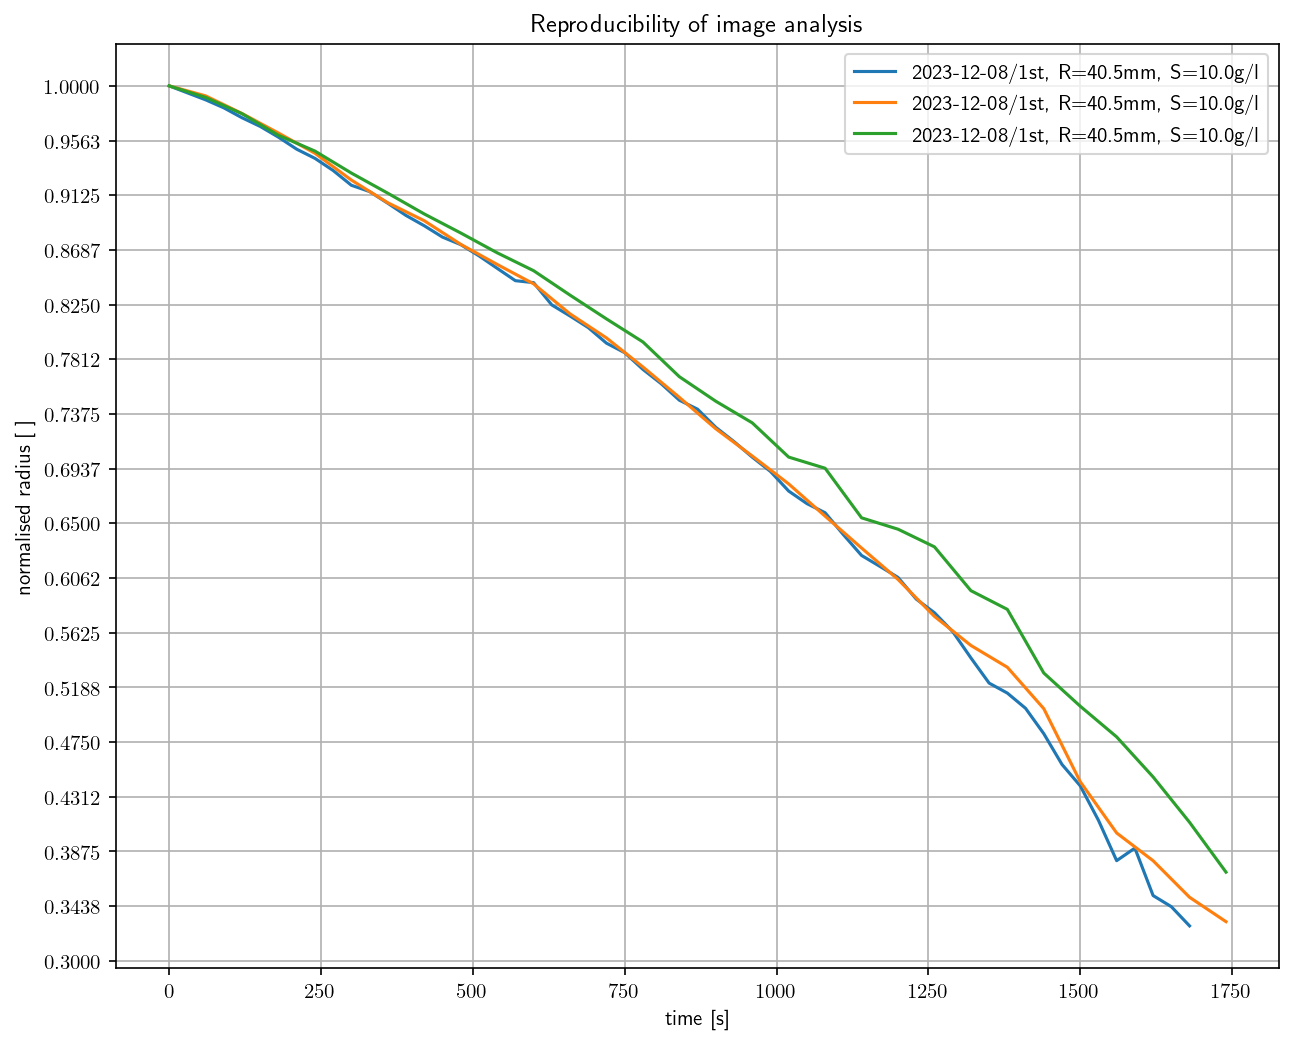

In [11]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinder = '2023-12-08/1st'

plt.figure(figsize=(10,8),dpi=150)
plt.rcParams['text.usetex'] = True

for repetition in ['/contours/','/contours_rev1/','/contours_rev2/']:
    dirContours = directory+cylinder+repetition
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)

    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii/radii[0],
            label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

plt.grid()
plt.legend()
plt.yticks(ticks=np.linspace(0.3,1,17))
plt.xlabel('time [s]')
plt.ylabel('normalised radius [ ]')
plt.title('Reproducibility of image analysis')
plt.show()

# Radius vs time

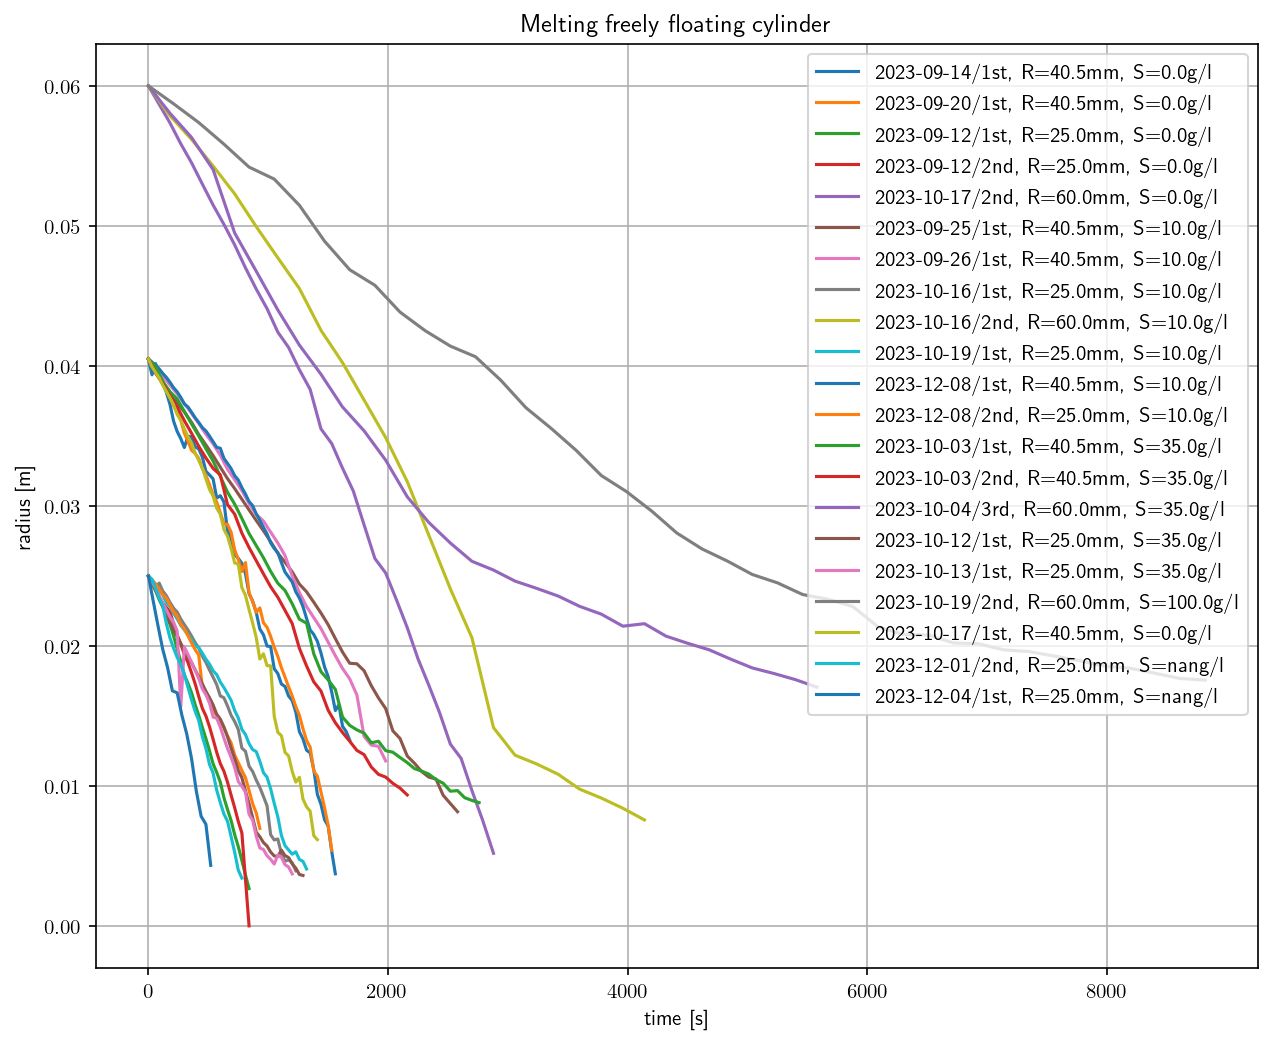

In [106]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-10-19/2nd', # S=100
             '2023-10-17/1st', # NR
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,8),dpi=150)
plt.rcParams['text.usetex'] = True

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii,
            label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

## Fitting stuff to radii

20.5
20.9


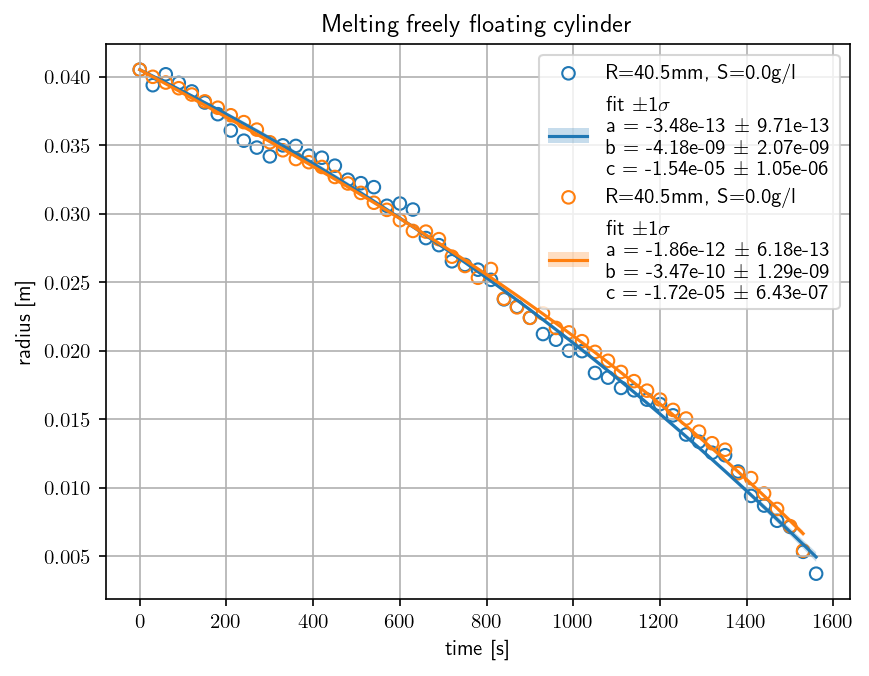

9.511884715392014e-05

In [80]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)

plt.figure(dpi=150)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
        
    if exp_radius!=0.0405: continue
    if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.scatter(contours_per_shot*interval*np.arange(len(radii)),radii,
                label=f'R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l',
                edgecolors=myColours[ic],facecolors='none') # one shot every 30 seconds
    
    # _ = sigmoid_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,exp_y0=exp_radius,boolPlot=1)
    # _, _ = polynomial_fitting(contours_per_shot*interval*np.arange(len(radii)),radii,degree=3,boolPlot=1)
    x = contours_per_shot*interval*np.arange(len(radii))
    res, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x[:],ydata=radii[:],color=myColours[ic],boolRetSigmas=True,legend=False,draw=1)
    print(exp_wt)

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

# Nusselt vs time

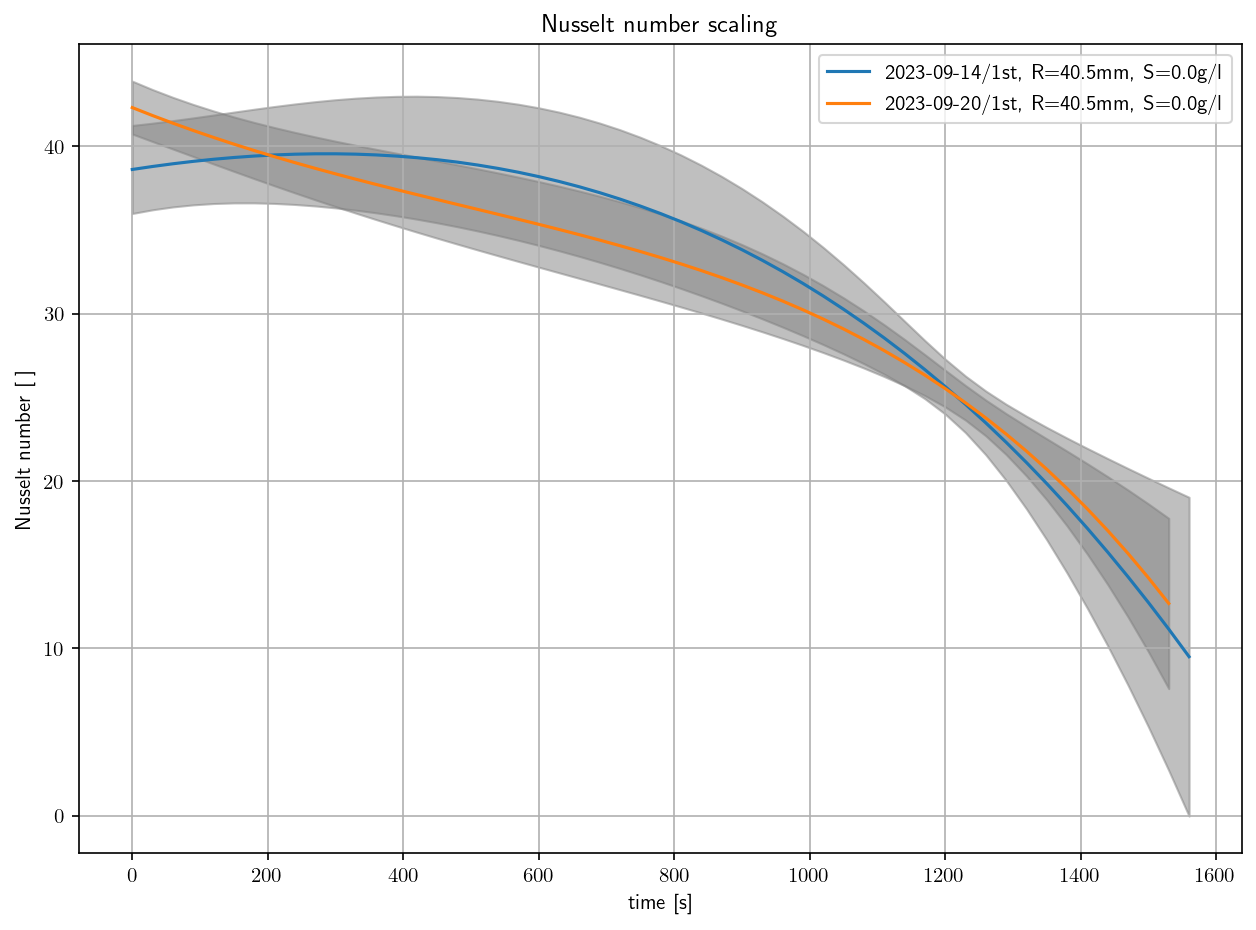

In [413]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,7),dpi=150)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    # print(contours_per_shot)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    if exp_radius!=0.0405 : continue
    if exp_sal!=0.0 : continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    x = contours_per_shot*interval*np.arange(len(radii))
    result, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x,ydata=radii,draw=False,boolRetSigmas=True)
    uNusselt_numbers = uNu_fit(params=result['params'],t=x,r0=radii[0],T_water=exp_wt)
    value = np.array([i.nominal_value for i in uNusselt_numbers])
    std = np.array([i.std_dev for i in uNusselt_numbers])
    plt.plot(x,value,label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') 
    plt.fill_between(x,value+std,value-std,color='grey',alpha=0.5)
    
    # # only for bootstrapping
    # areas_fit = np.pi*result['func'](x)**2
    # uareas = unumpy.uarray(areas_fit,sigma)
    # Nusselt_numbers = uNu_areas(uareas,exp_wt,interval*contours_per_shot)
    # # error band with bootstrapping
    # for i in range(1000):
    #     a,b,c = bootstrap(result=result)
    #     if i==0: band = Nu_areas(np.pi*np.polyval([a,b,c,radii[0]],x)**2,exp_wt,interval*contours_per_shot) # these are areas that get fed to the nusselt number calculator
    #     band = np.vstack((band,Nu_areas(np.pi*np.polyval([a,b,c,radii[0]],x)**2,exp_wt,interval*contours_per_shot)))
    # std_band = np.std(band,axis=0)
    # a,b,c = result['params']['a']['value'],result['params']['b']['value'],result['params']['c']['value']
    # best_fit = Nu_areas(np.pi*np.polyval([a,b,c,d],x)**2,exp_wt,interval*contours_per_shot)
    # plt.fill_between(x,best_fit+std_band,best_fit-std_band,
    #                  color='grey',alpha=0.5)
    
plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Nusselt number [ ]')
plt.title('Nusselt number scaling')

plt.show()

# Nusselt vs Rayleigh

3


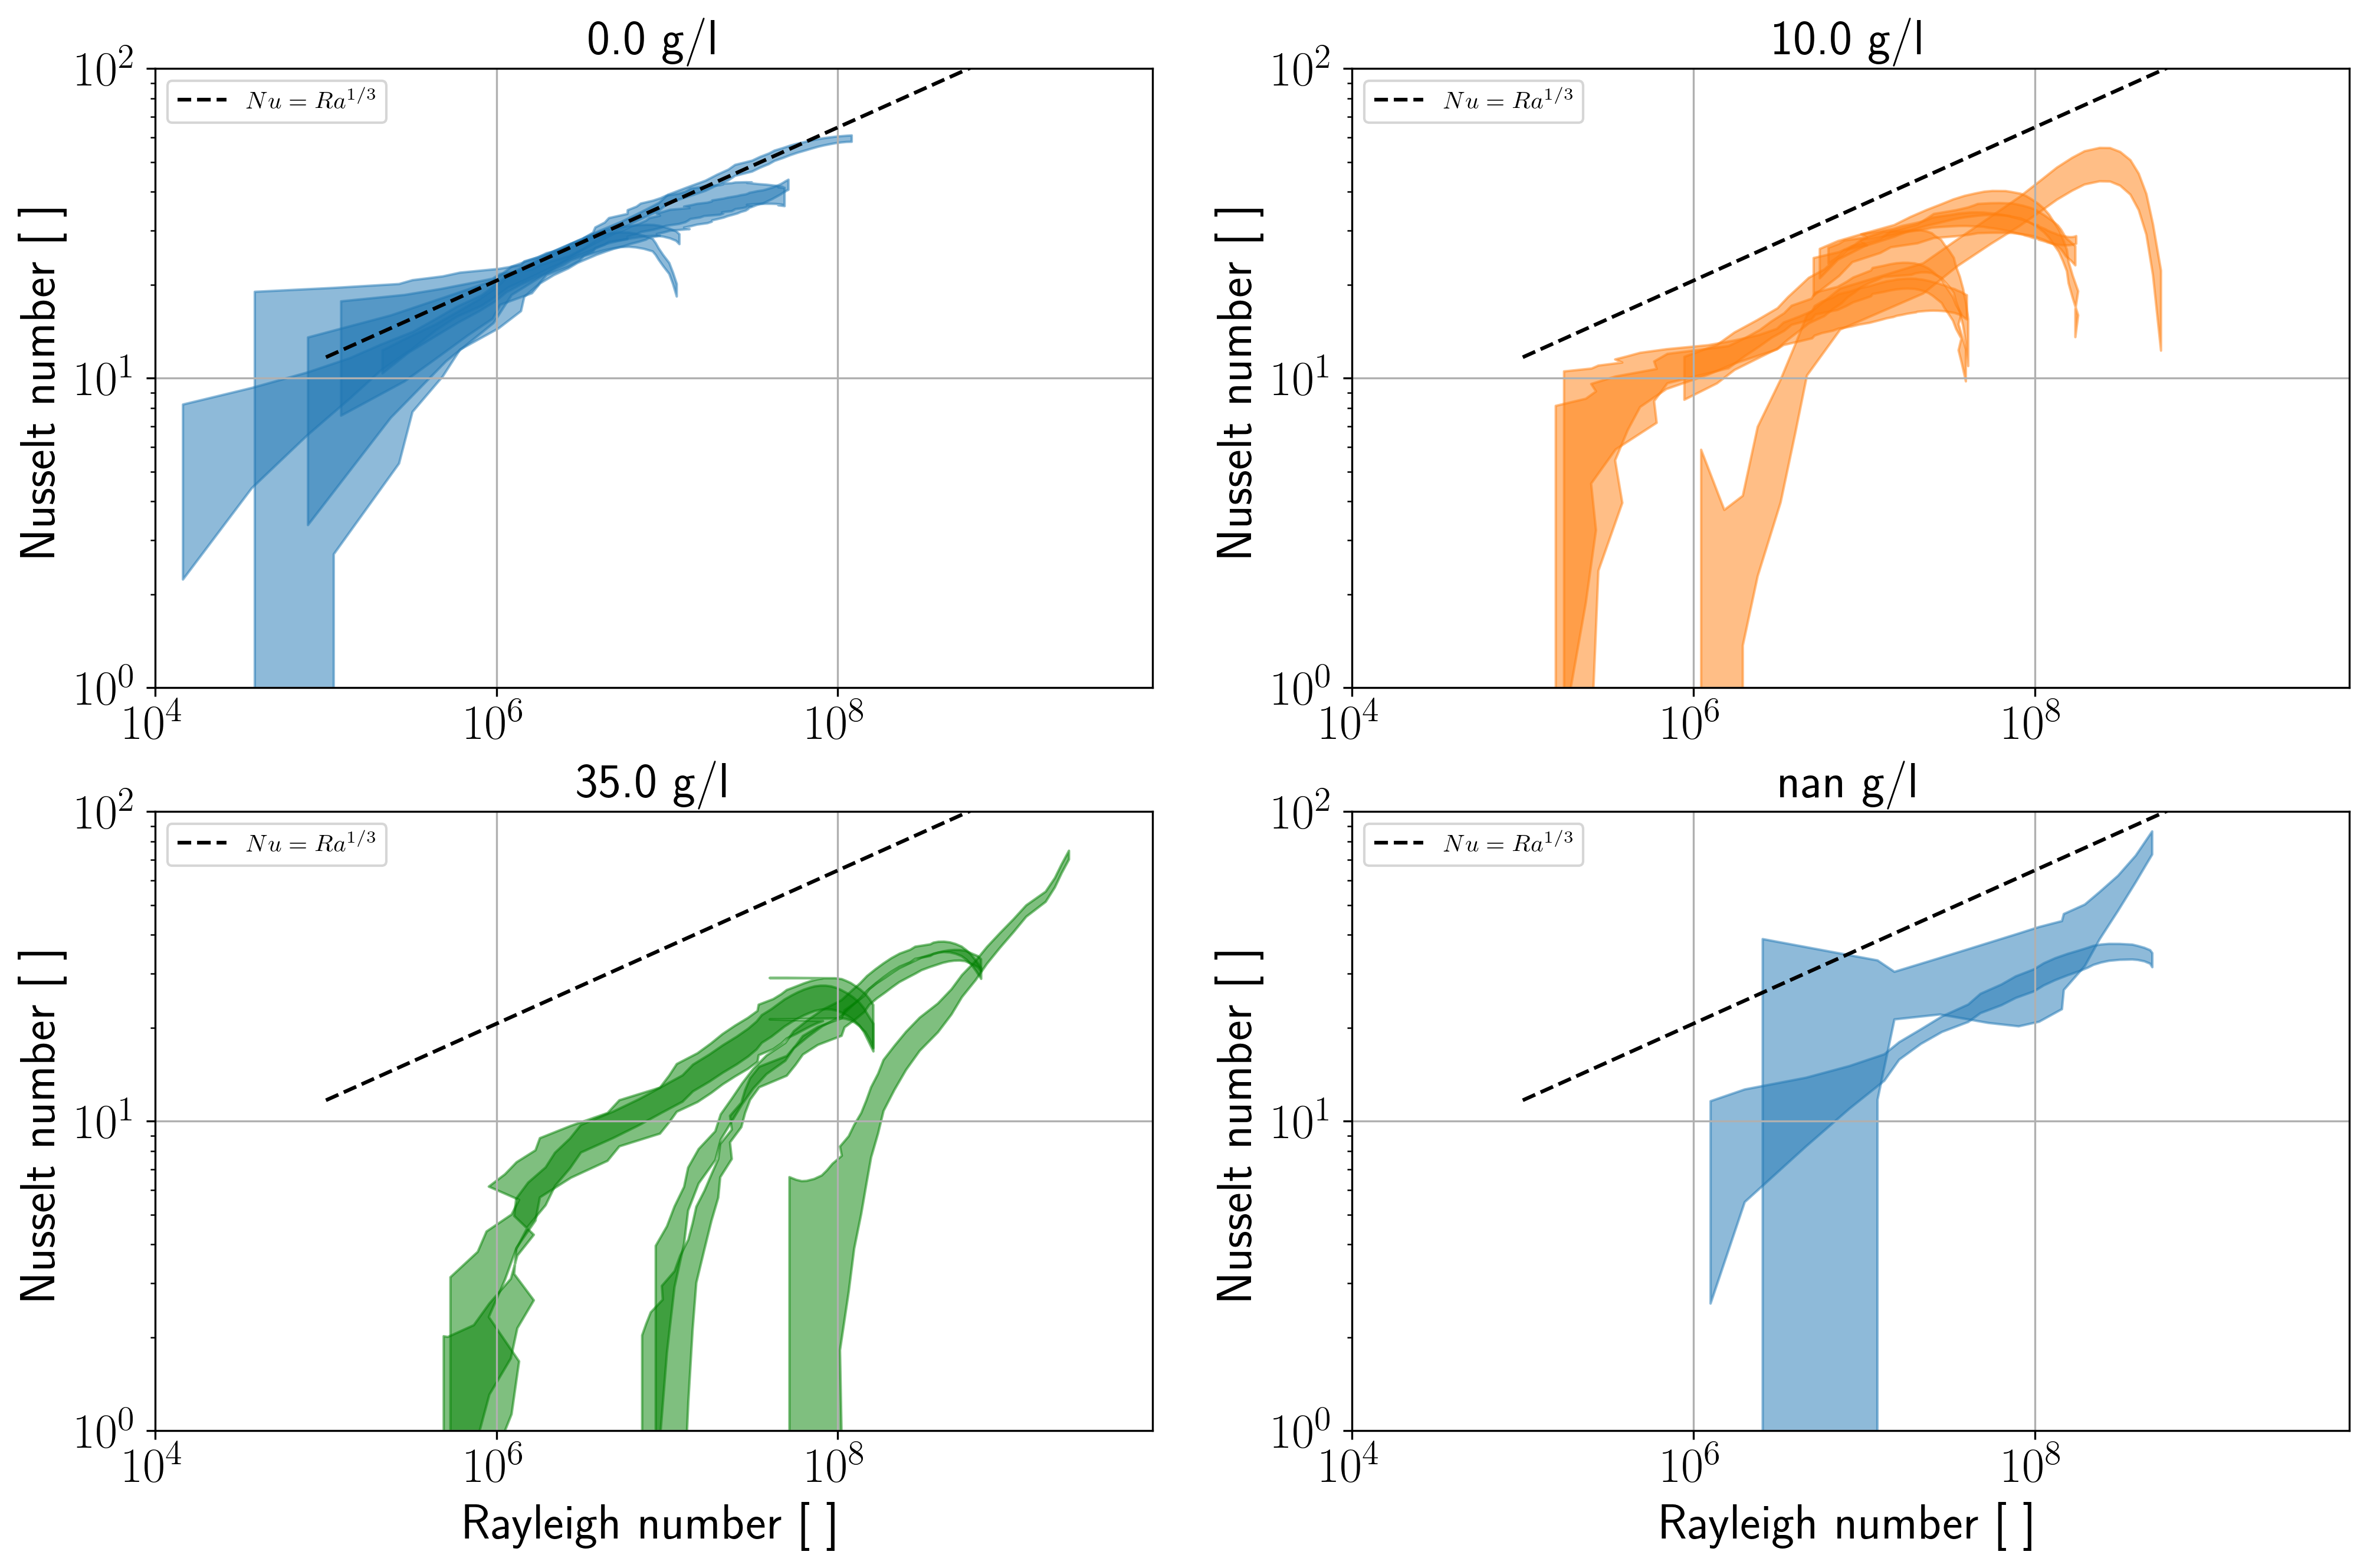

In [82]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

chosen_radii = [0.025,0.0405,0.06]
chosen_salts = [0.,10.,35.,]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,10),dpi=300)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    if cylinder=='2023-12-08/1st': print(contours_per_shot)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    radii = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            initialArea = np.pi*exp_radius**2 # px
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # px/m2
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
        radii.append(radius)    
    
    radii = correct_outliers(radii)

    conversion = info[1,1]/radii[0] # m/px
    radii = np.array(radii)
    radii *= conversion

    if exp_sal == 0.:
        axi = ax.flatten()[0]
    elif exp_sal == 10.:
        axi = ax.flatten()[1]
    elif exp_sal == 35.:
        axi = ax.flatten()[2]
    elif np.isnan(exp_sal):
        axi = ax.flatten()[3]

    Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
    if np.isnan(exp_sal): Rayleigh_numbers=Ra_heavyWater(radii,exp_wt)
    
    x = contours_per_shot*interval*np.arange(len(radii))
    result, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x,ydata=radii,draw=False,boolRetSigmas=True)
    uNusselt_numbers = uNu_fit(params=result['params'],t=x,r0=radii[0],T_water=exp_wt)
    value = np.array([i.nominal_value for i in uNusselt_numbers])
    std = np.array([i.std_dev for i in uNusselt_numbers])
    # axi.scatter(Rayleigh_numbers,value,
    #             label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l',zorder=100,
    #             marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
    #             edgecolor=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
    #             facecolor='none')
    axi.fill_between(Rayleigh_numbers,value+std,value-std,
                     color=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
                     alpha=0.5)
    axi.set_title(f'{exp_sal} g/l',fontsize=20)
    

for axi in ax.flatten():
    axi.plot(np.logspace(5,9,50),25*np.logspace(-1,2,50)**.33,linestyle='--',c='k',label=r'$Nu=Ra^{1/3}$')
    # axi.plot(np.logspace(5,9,50),25*np.logspace(-1,2,50)**.25,linestyle='-.',c='k',label='.25')
    axi.grid()
    axi.legend()
    axi.set_ylabel('Nusselt number [ ]',fontsize=20)
    axi.set_xlabel('Rayleigh number [ ]',fontsize=20)
    if axi == ax.flatten()[0] or axi == ax.flatten()[1]:
        axi.set_xlabel('')

    axi.set_yscale('log')
    axi.set_xlim(1e4,7e9)
    axi.set_xscale('log')
    axi.set_ylim(1e0,1e2)

    axi.tick_params(axis='x', labelsize=20)
    axi.tick_params(axis='y', labelsize=20)

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/NuRa.eps',format='eps',bbox_inches='tight')
plt.show()

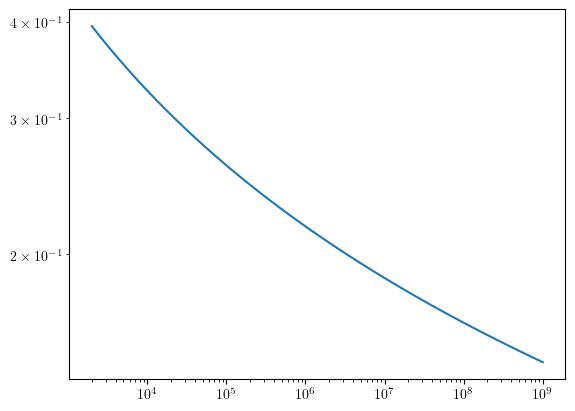

In [424]:
x = np.logspace(1.1,3,50)
plt.plot(x**3,1/np.log(x))
# plt.plot(x**3,x*.33)
plt.yscale('log')
plt.xscale('log')
plt.show()

# Plot all contours

### Freshwater

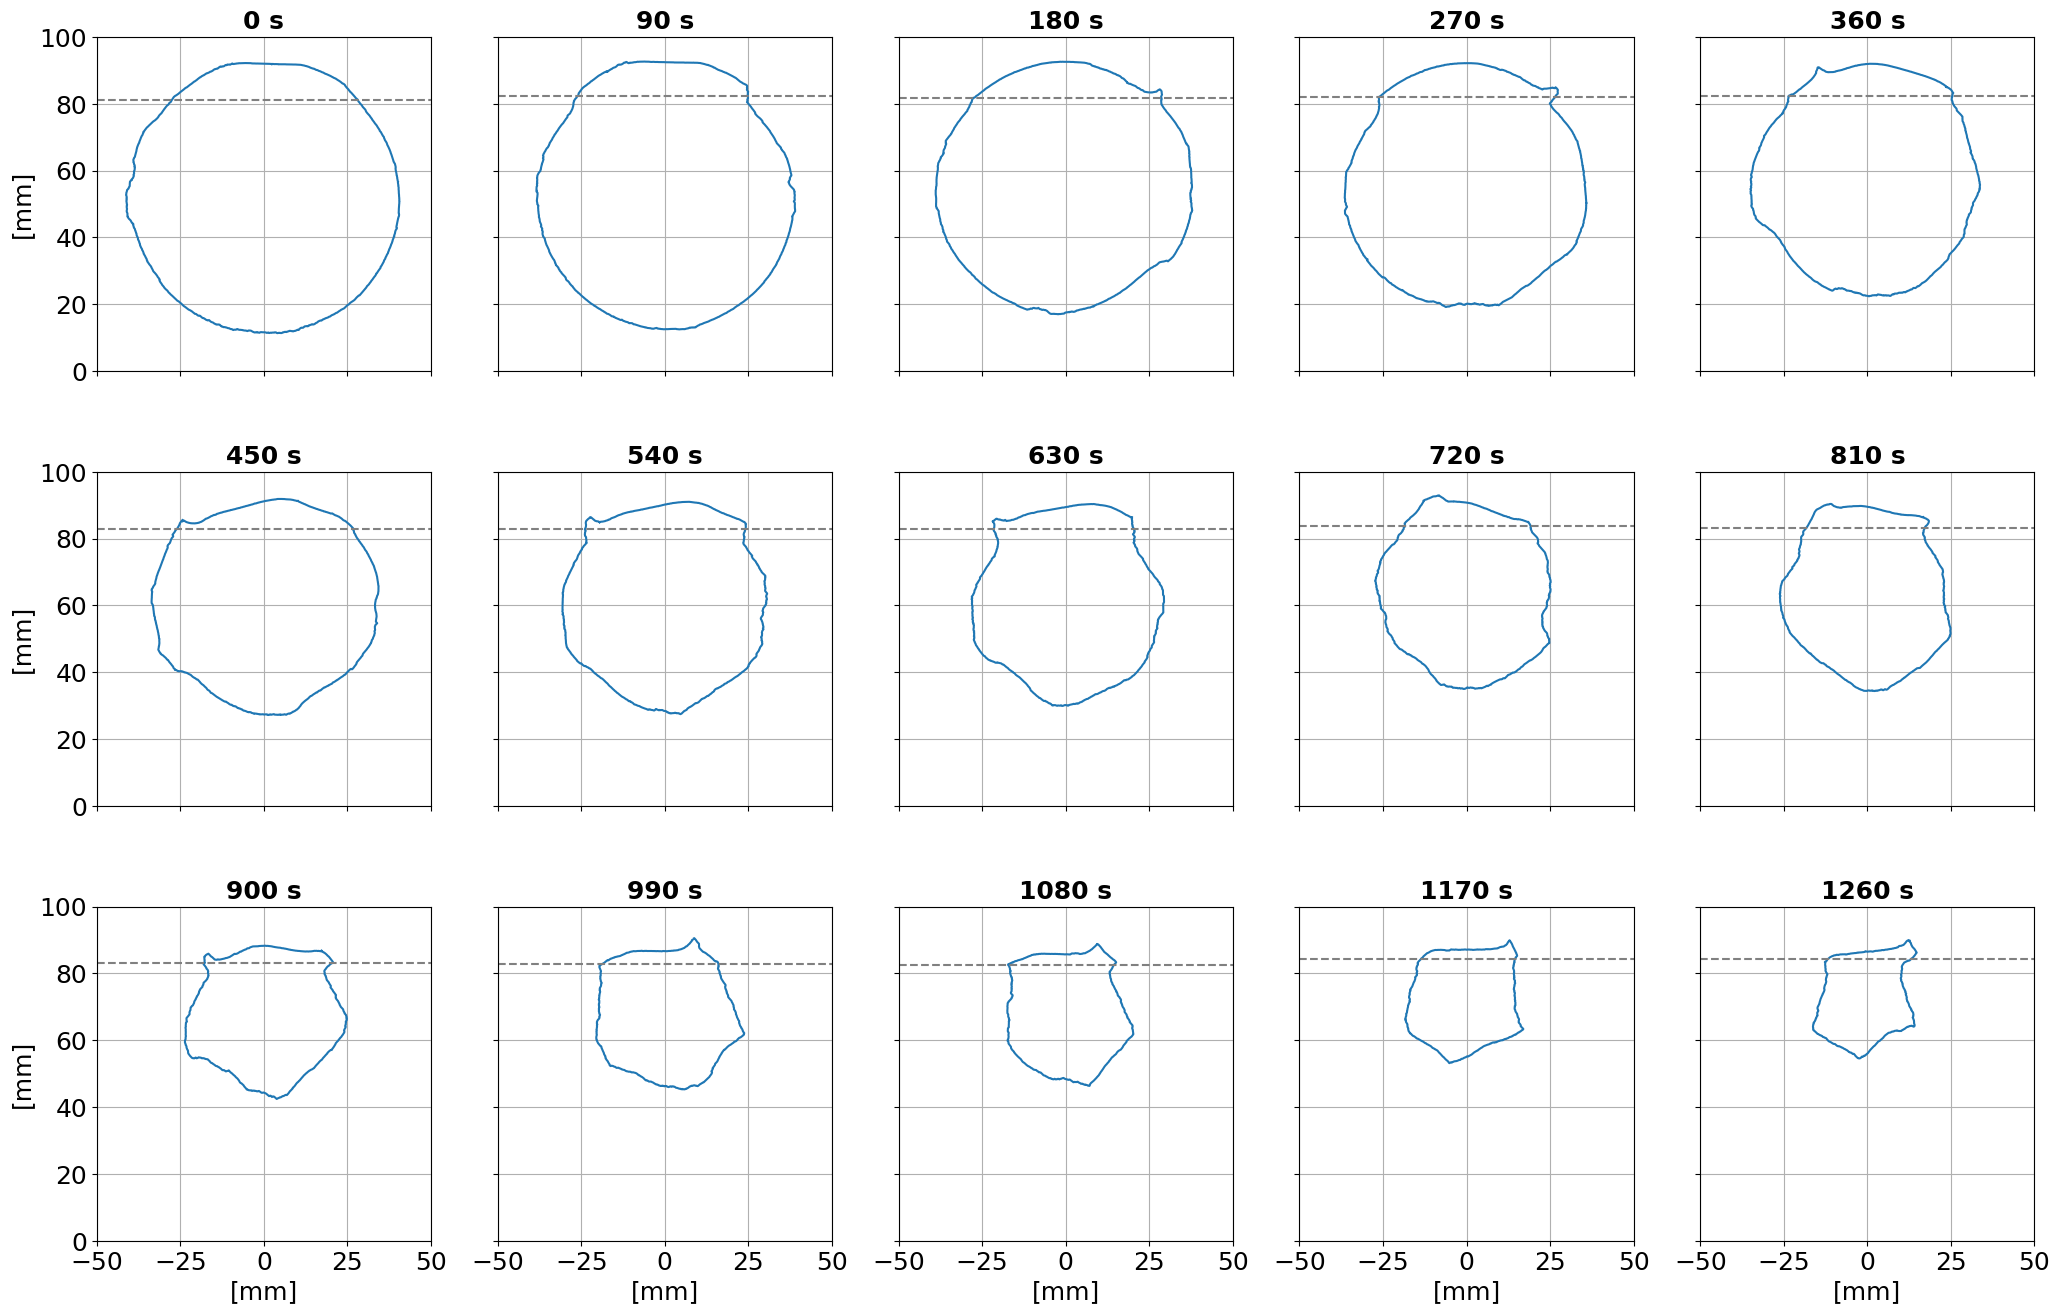

In [208]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-20/'
cylinders = ['1st']

fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(25,16))

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))

    radii = []
    step = 3
    for it,contourPATH in enumerate(contoursPATH[:-7:step]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        xcenter = np.mean(contour,axis=0)[0]
        
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1])

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].hlines(wl,-50,50,linestyles='--',colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set_aspect('equal')
    axi.set_xlabel('[mm]',fontsize=18)
    axi.set_ylabel('[mm]',fontsize=18)
    if it%5!=0: 
        axi.set_ylabel('')
        axi.set_yticklabels('')
    if it<10:
        axi.set_xlabel('')
        axi.set_xticklabels('')
    axi.set_title(f'{it*30*step} s',fontweight='bold',fontsize=18)
    axi.set_ylim(0,100)
    axi.set_xlim(-50,50)
    axi.tick_params(axis='x', labelsize=18)
    axi.tick_params(axis='y', labelsize=18)
    axi.grid()

plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/freshWater.eps',format='eps',bbox_inches='tight')
plt.show()

### Heavy water

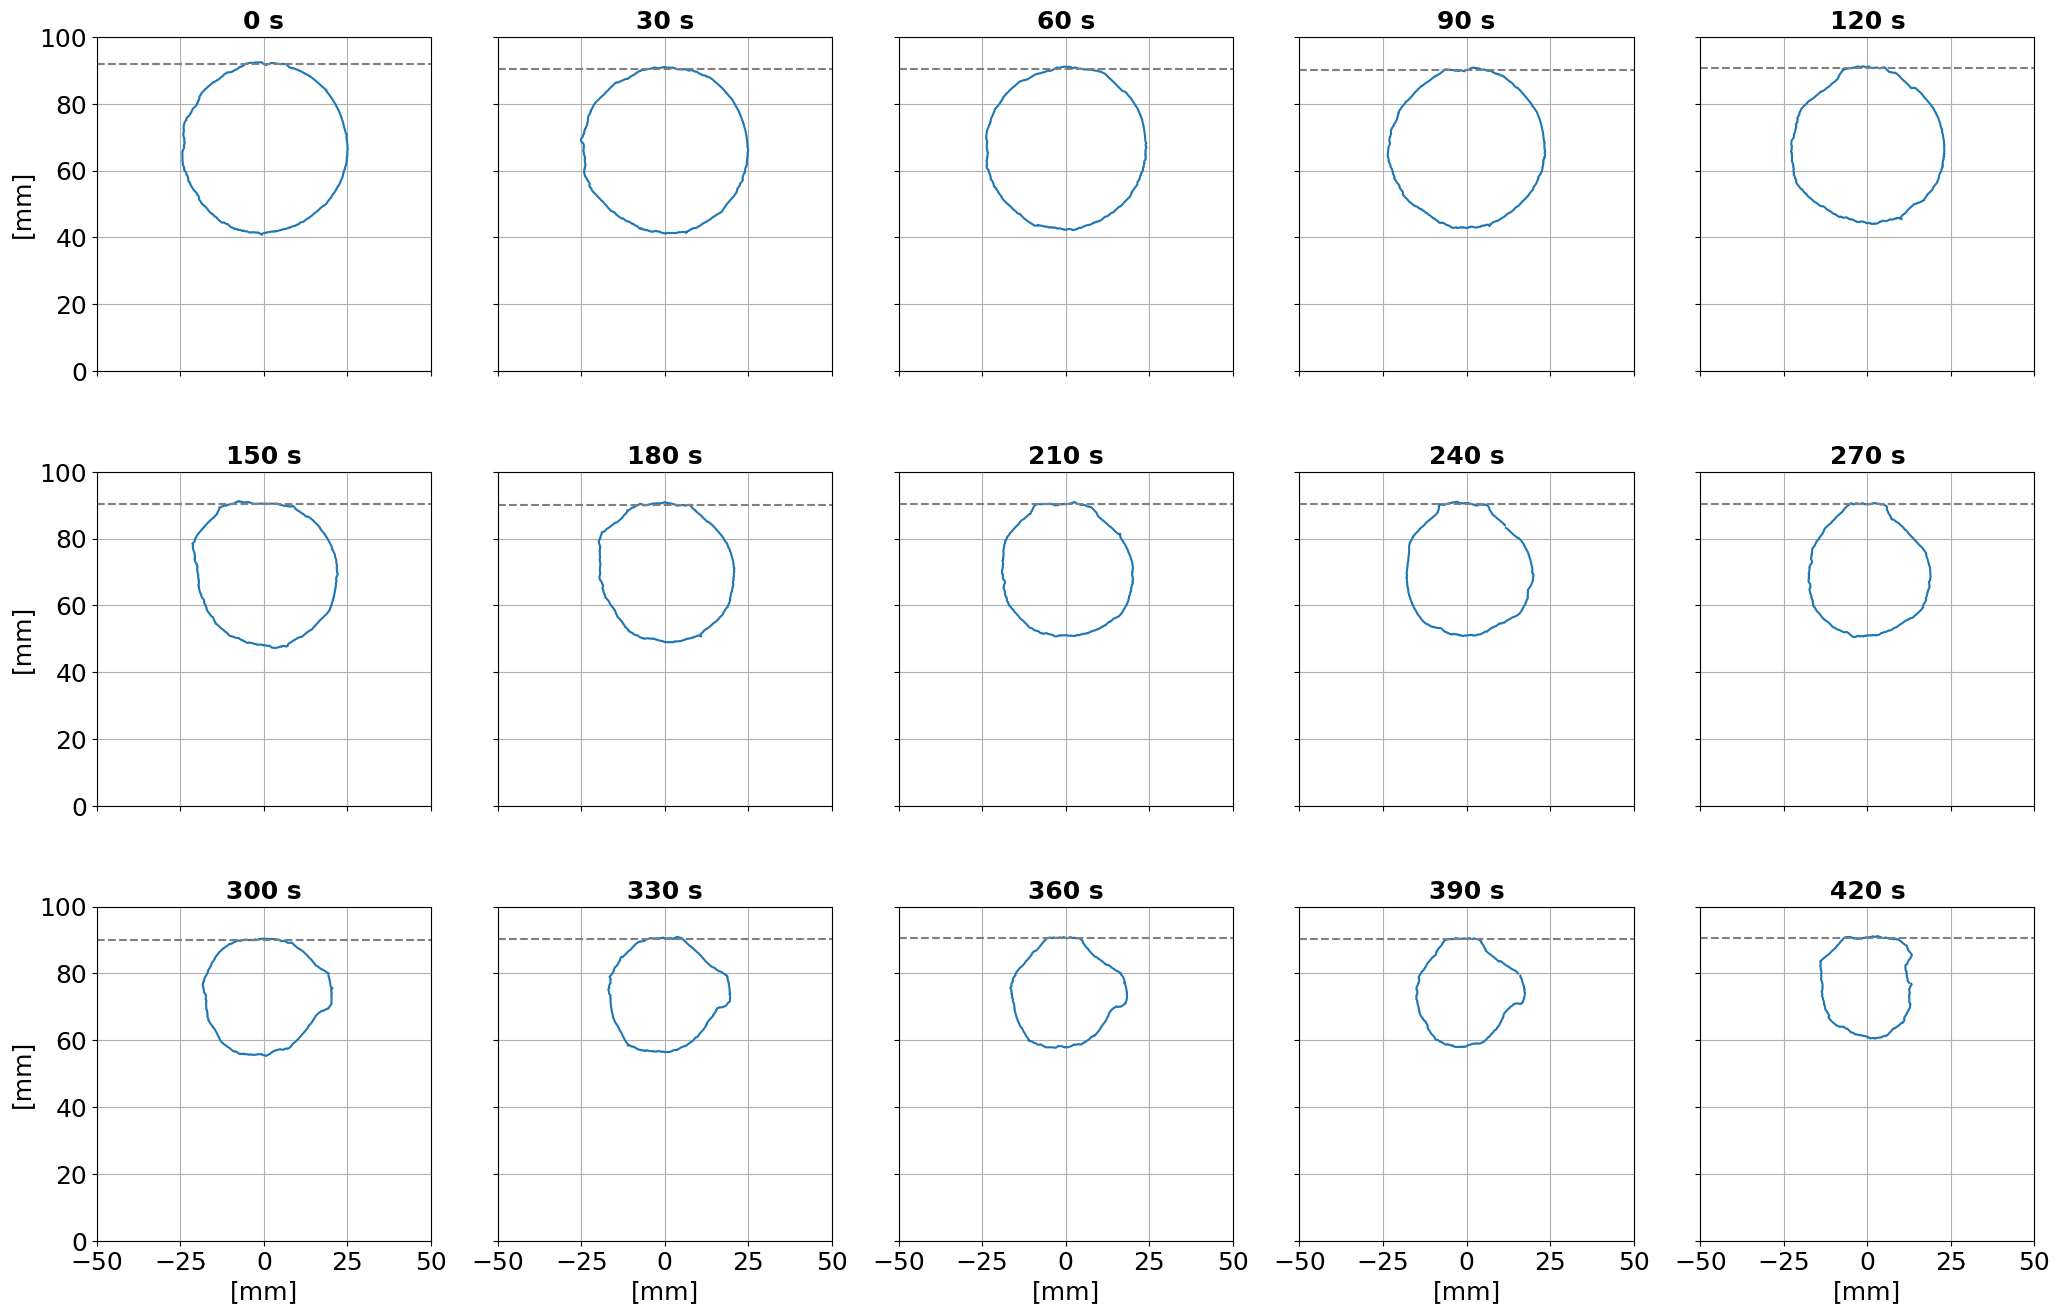

In [207]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/'
cylinders = ['2nd']

fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(25,16))

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))

    radii = []
    step = 1
    for it,contourPATH in enumerate(contoursPATH[::step]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*8/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        xcenter = np.mean(contour,axis=0)[0]
        
        if it==len(ax.flatten()):break
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1])

        wl = findWL(contour,densityRatio=1003/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].hlines(wl,-50,50,linestyles='--',colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set_aspect('equal')
    axi.set_xlabel('[mm]',fontsize=18)
    axi.set_ylabel('[mm]',fontsize=18)
    if it%5!=0: 
        axi.set_ylabel('')
        axi.set_yticklabels('')
    if it<10:
        axi.set_xlabel('')
        axi.set_xticklabels('')
    axi.set_title(f'{it*30*step} s',fontweight='bold',fontsize=18)
    axi.set_ylim(0,100)
    axi.set_xlim(-50,50)
    axi.tick_params(axis='x', labelsize=18)
    axi.tick_params(axis='y', labelsize=18)
    axi.grid()

plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/heavyWater.eps',format='eps',bbox_inches='tight')
plt.show()

### Salty water

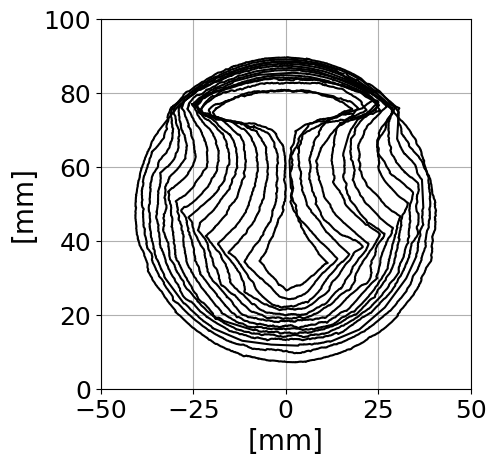

In [198]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-08/'
cylinders = ['1st']

plt.figure()

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::4]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*3.5/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        com,_ = hydrostasy(contour,densityRatio=917/1005)
        xcenter = com.x
        plt.plot(contour[:,0]-xcenter,contour[:,1],c='k')

plt.gca().set_aspect('equal')
plt.ylim(0,100)
plt.xlim(-50,50)
plt.ylabel('[mm]',fontsize=20)
plt.xlabel('[mm]',fontsize=20)
plt.grid()
plt.gca().tick_params(axis='x', labelsize=18)
plt.gca().tick_params(axis='y', labelsize=18)

m = -230/250
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/saltyWater.eps',format='eps',bbox_inches='tight')
plt.show()

### No rotation

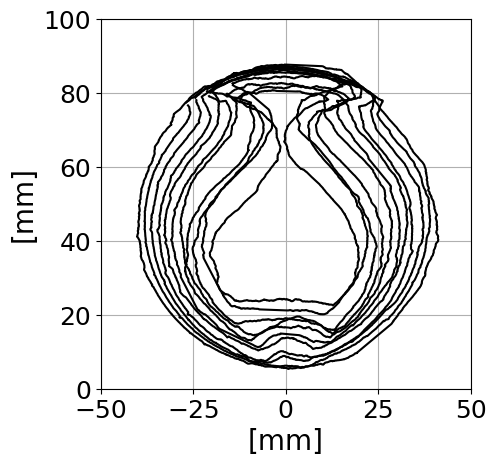

In [197]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-10-17/'
cylinders = ['1st']

plt.figure()

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[:-15:3]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        com,_ = hydrostasy(contour,densityRatio=917/1005)
        xcenter = com.x
        plt.plot(contour[:,0]-xcenter,contour[:,1],c='k')

plt.gca().set_aspect('equal')
plt.ylim(0,100)
plt.xlim(-50,50)
plt.ylabel('[mm]',fontsize=20)
plt.xlabel('[mm]',fontsize=20)
plt.grid()
plt.gca().tick_params(axis='x', labelsize=18)
plt.gca().tick_params(axis='y', labelsize=18)

m = -230/250
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/freshWaterNR.eps',format='eps',bbox_inches='tight')
plt.show()

# Find waterline

### Test on one contour

NameError: name 'PolyArea' is not defined

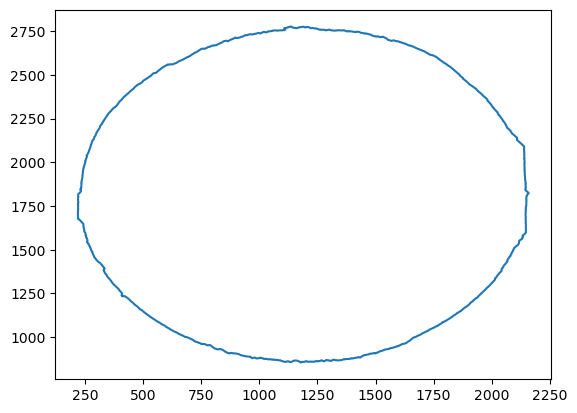

In [7]:
plt.figure()
contour = np.genfromtxt(contoursPATH[1],dtype='float',delimiter=',').T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

plt.plot(contour[:,0],contour[:,1],label='orig')



immersedPG = makePolygonBelow(contour,findWL(contour))
plt.plot(immersedPG[:,0],immersedPG[:,1],label='immersed')


plt.legend()
plt.gca().set_aspect('equal')
plt.show()

### Apply to all contours

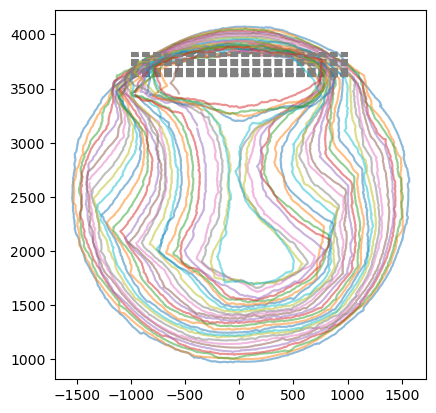

In [106]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-26/'
cylinders = ['1st']

plt.figure()

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
        contour[:,1 ] = -contour[:,1] + shift
        # plt.plot(contour[:,0],contour[:,1])
        xcenter = np.mean(contour,axis=0)[0]
        # plt.scatter(np.mean(contour,axis=0)[0],np.mean(contour,axis=0)[1])
        plt.plot(contour[:,0]-xcenter,contour[:,1],alpha=.5)

        wl = findWL(contour)
        plt.hlines(wl,-1000,1000,linestyles='--',colors='grey')


plt.gca().set_aspect('equal')

plt.show()

# Find stability

### Test on one contour

x-location difference CoM-CoB = -2.71 px


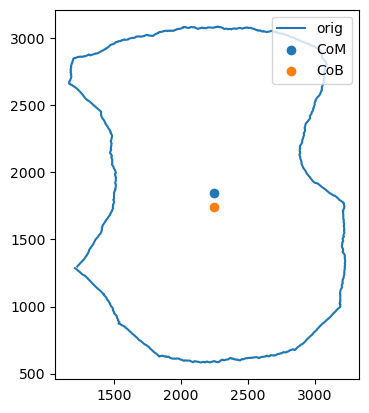

In [107]:
plt.figure()
contour = np.genfromtxt(contoursPATH[15],dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

plt.plot(contour[:,0],contour[:,1],label='orig')



com,cob = hydrostasy(contour)

plt.scatter(com.x,com.y,label='CoM')
plt.scatter(cob.x,cob.y,label='CoB')
print(f'x-location difference CoM-CoB = {com.x-cob.x:.2f} px')

plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
plt.show()

### Check rotations of contour

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


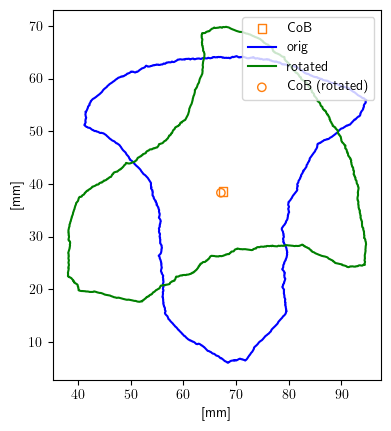

SUM Stability index = 96.0 degrees
DIFF Stability index = 47.5 degrees
NEW Stability index = 79.48102930289238


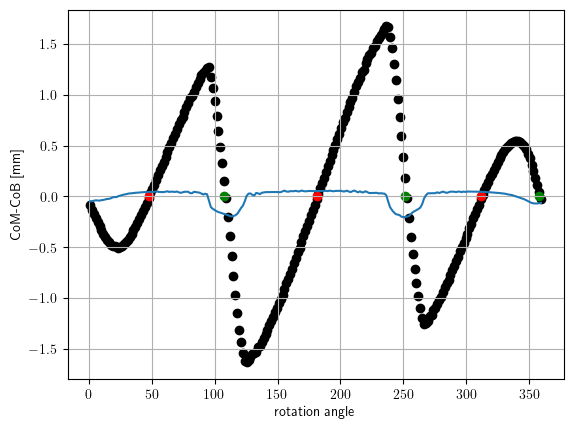

In [253]:
# find calibration
contour = np.genfromtxt(contoursPATH[0],dtype='float',delimiter=',')
radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
calibration = radius/0.0405 # px/m

plt.figure()
contour = np.genfromtxt(contoursPATH[20],dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 
contour = contour*1e3/calibration # in mm
rotAngle = 60
com,cob = hydrostasy(contour,densityRatio=917/1005)
plt.scatter(cob.x,cob.y,label='CoB',facecolors='none',edgecolors='tab:orange',marker='s')
rotatedCont = rotate(contour,[com.x,com.y],rotAngle)
plt.plot(contour[:,0],contour[:,1],color='blue',label='orig')
plt.plot(rotatedCont[:,0],rotatedCont[:,1],color='green',label='rotated')
del com

com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
# plt.title(f'Rotation angle = {rotAngle} degrees \n com.x-cob.x = {com.x-cob.x:.2f}')
plt.scatter(cob.x,cob.y,label='CoB (rotated)',facecolors='none',edgecolors='tab:orange')
# plt.arrow(com.x,com.y,0,-10,color='green',linestyle='--',width=1)
# plt.arrow(cob.x,cob.y,0,10,color='purple',linestyle='--',width=0.1)
plt.xlabel('[mm]')
plt.ylabel('[mm]')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/rotationStability.eps',format='eps',bbox_inches='tight')
plt.show()

plt.figure()
angleStep = 1.5
stability = np.zeros((int(360/angleStep),2))

for i,angle in enumerate(np.arange(1,360,angleStep)):
    com,_ = hydrostasy(contour,densityRatio=917/1005)
    rotatedCont = rotate(contour,[com.x,com.y],angle)
    del com
    com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
    stability[i] = angle, com.x-cob.x

plt.scatter(stability[:,0],stability[:,1],c='k')
zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
index_zc = stability[zero_crossings,0]
# plt.scatter(index_zc,np.zeros_like(index_zc),c='red')
plt.plot(stability[:,0],np.gradient(stability[:,1]))
unstablePointsAngles = []
for i in zero_crossings:
    if np.gradient(stability[:,1])[i]<0:
        plt.scatter(stability[i,0],0,c='green')
    else:
        plt.scatter(stability[i,0],0,c='red')
        unstablePointsAngles.append(stability[i,0])

# SUM is how distant are the two closest unstable equilibria
print(f'SUM Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')
# DIFF is how distant is the closest unstable equilibrium 
print(f'DIFF Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])} degrees')
print(f'NEW Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))}')

plt.ylabel('CoM-CoB [mm]')
plt.xlabel('rotation angle')
plt.grid()
# plt.title(f'Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1])):.2f}')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/stabilityIndex.eps',format='eps',bbox_inches='tight')
plt.show()

### Apply to all contours

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


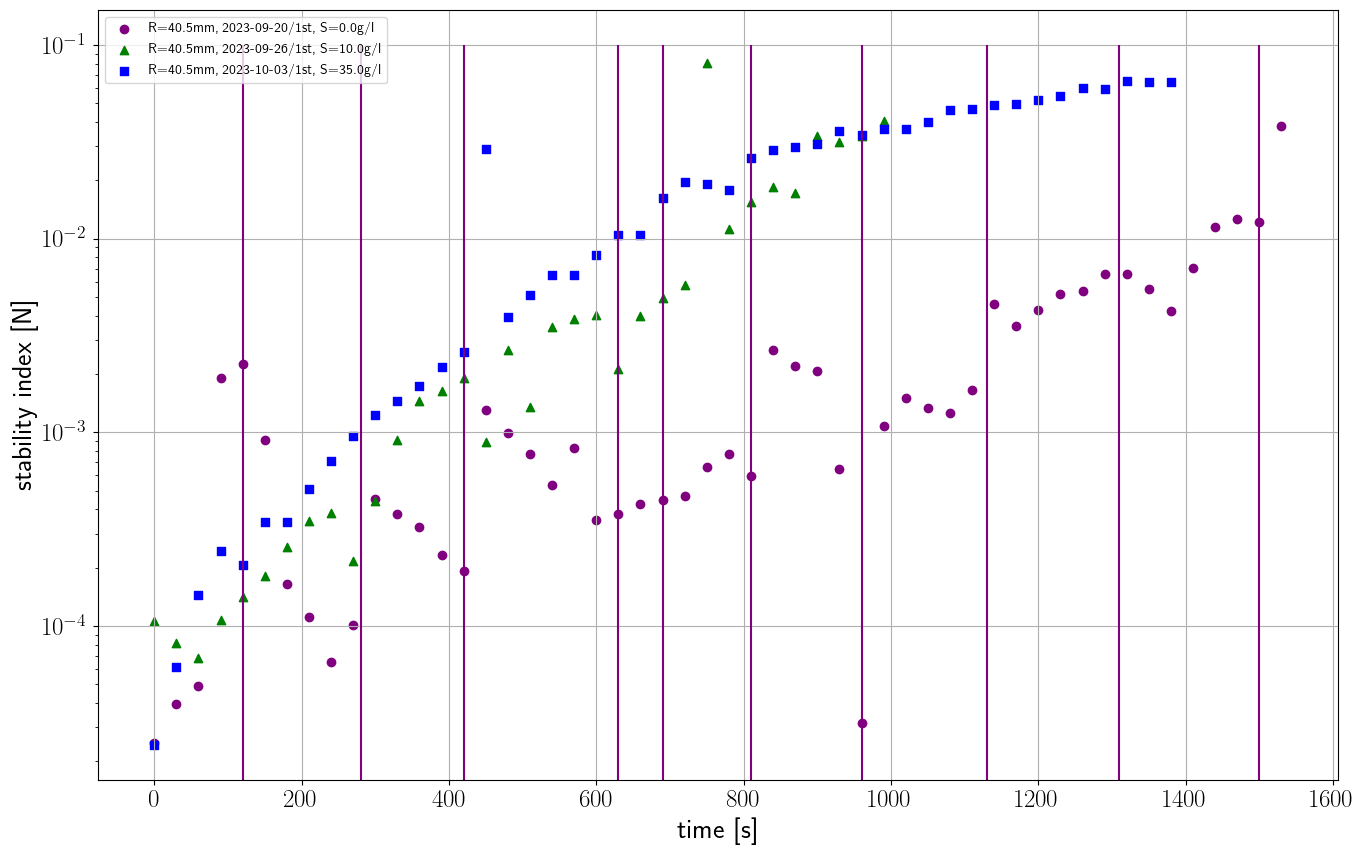

In [289]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-20/1st','2023-09-26/1st','2023-10-03/1st']

plt.rcParams['text.usetex'] = True
plt.figure(figsize=(16,10))

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour /= conversion
        area = PolyArea(contour[:,1],contour[:,0]) # m2
        buoyancy = area*917*g # N/m
        
        angleStep = 1.5
        stability = np.zeros((int(360/angleStep),2))

        for i,angle in enumerate(np.arange(1,360,angleStep)):
            com,_ = hydrostasy(contour) ### CHANGE SALTY OR FRESH
            rotatedCont = rotate(contour,[com.x,com.y],angle)
            del com
            com,cob = hydrostasy(rotatedCont)  ### CHANGE SALTY OR FRESH
            stability[i] = angle, com.x-cob.x

        zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
        index_zc = stability[zero_crossings,0]
        unstablePointsAngles = []
        for i in zero_crossings:
            if np.gradient(stability[:,1])[i]>0:
                unstablePointsAngles.append(stability[i,0])

        # print(f'Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')
        kwargs_ = [['o','purple'],
                  ['^','green'],
                  ['s','blue']]
        
        if it==0:
            plt.scatter(30*it,min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))/buoyancy,marker=kwargs_[ic][0],
                        c=kwargs_[ic][1],label=f'R={info[1,1]*1e3:.1f}mm, {cylinder}, S={info[1,0]}g/l')
        else:
            plt.scatter(30*it,min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))/buoyancy,marker=kwargs_[ic][0],
                        c=kwargs_[ic][1])

        
# draw rotation lines
for t in [12,28,42,63,69,81,96,113,131,150]: # rotation times of 09/20/1st
   plt.vlines(t*10,0,1e-1,colors='purple')
#for t in []: # rotation times of 09/20/1st
#    plt.vlines(t*10,25,375,colors='blue')

plt.ylabel('stability index [N]',fontsize=20)
plt.xlabel('time [s]',fontsize=20)
plt.grid()
plt.gca().tick_params(axis='x', labelsize=18)
plt.gca().tick_params(axis='y', labelsize=18)
plt.legend()
#plt.ylim(0,4000)
plt.yscale('log')
# plt.title('Rotations make the ice more stable.\n Salinity stratifies water, which makes stability increase over time.')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/stability.eps',format='eps',bbox_inches='tight')
plt.show()


# Fresh water level L/R

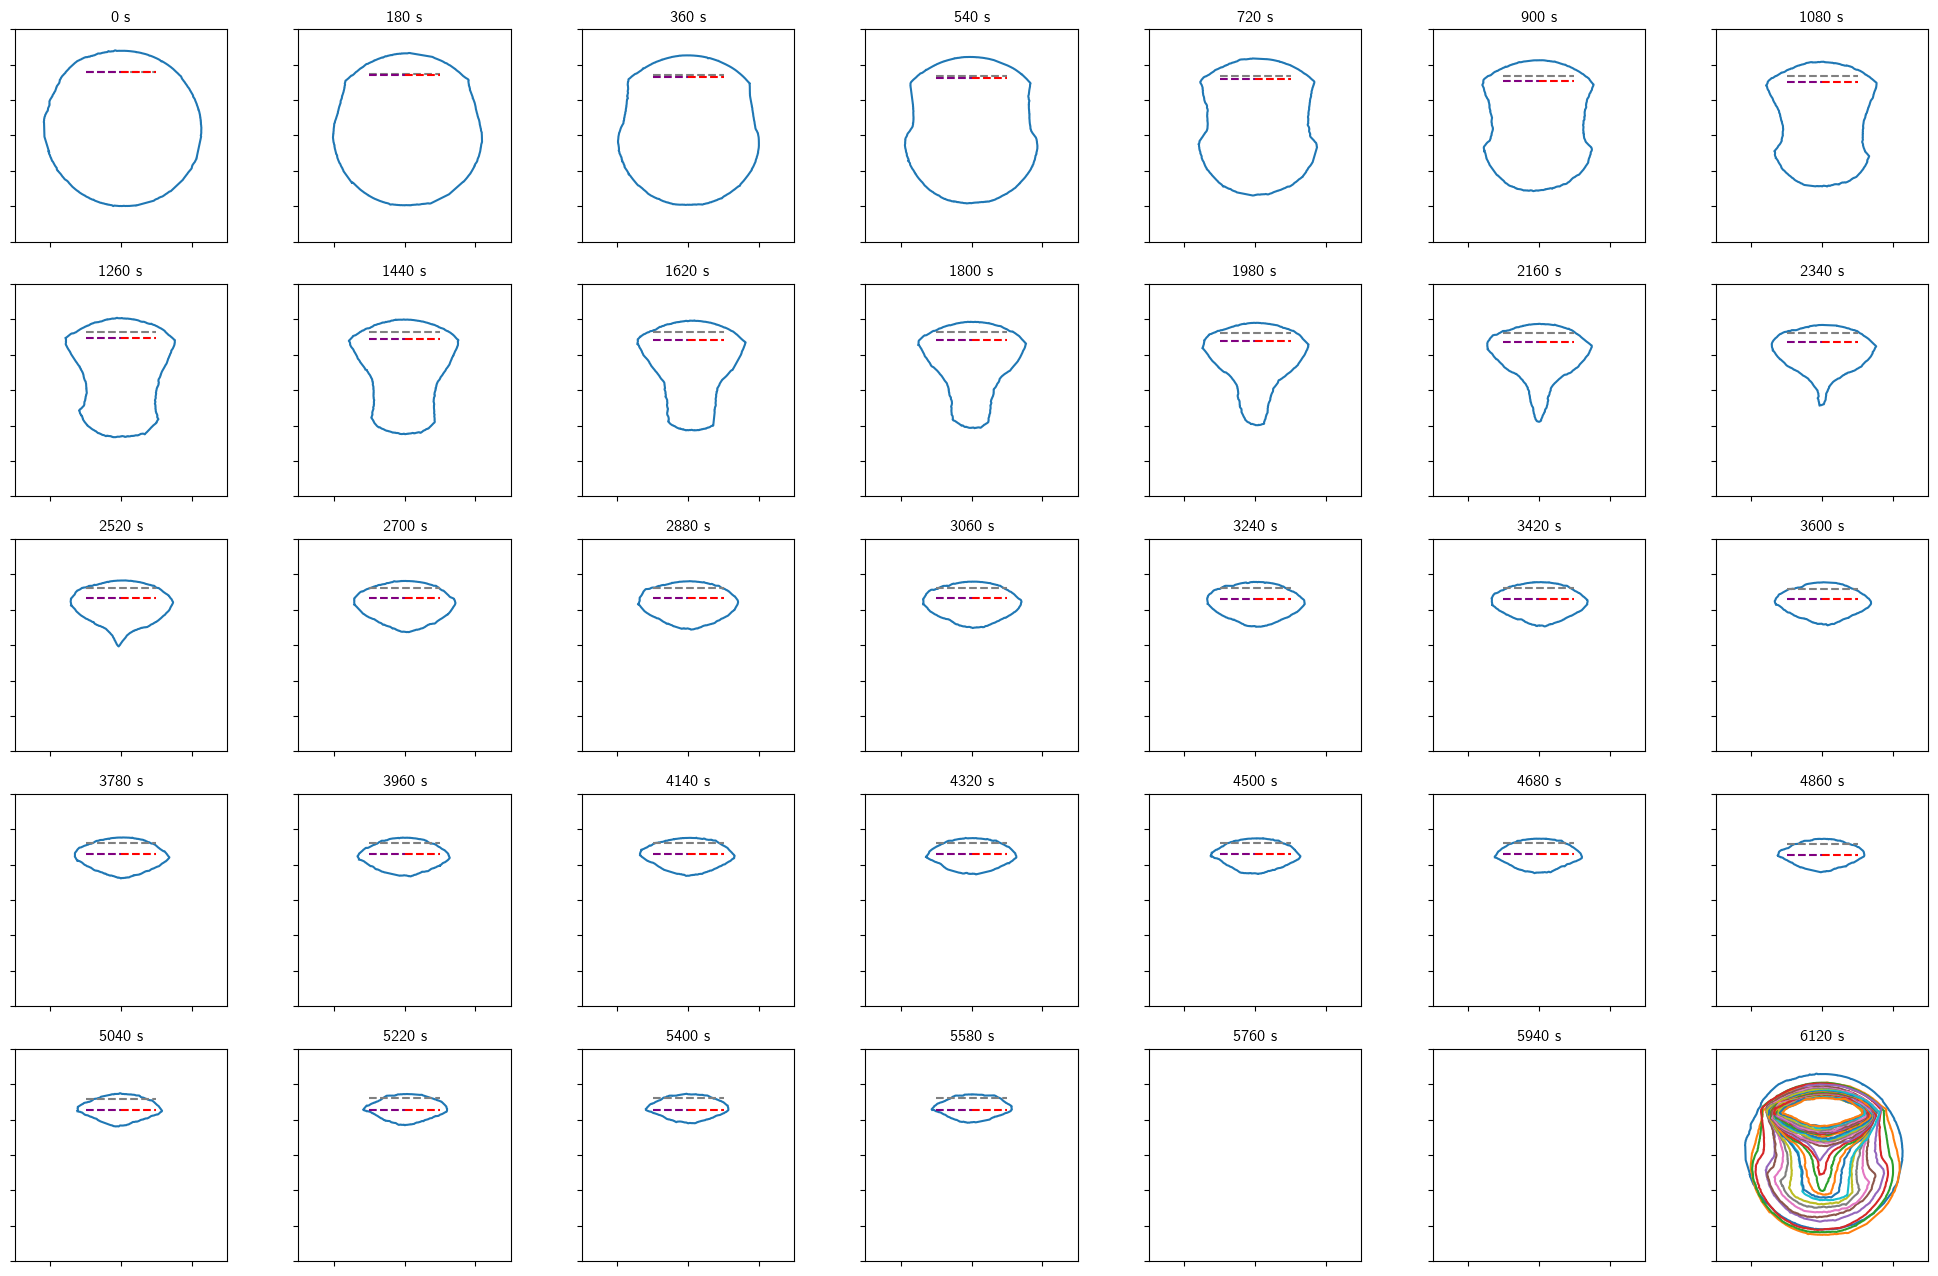

In [316]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-10-04/'
cylinders = ['3rd']

fig, ax = plt.subplots(nrows=5,ncols=7,figsize=(25,16))

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)


    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3 # straighten y direction
            initialArea = np.pi*.0405**2 # in m2
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # in px/m2
        contour[:,1 ] = -contour[:,1] + shift 
        moltenArea = initialArea - PolyArea(contour[:,1],contour[:,0])/conversion # in m2
        # find freshwater layer depth supposing that the meltwater spreads according to the position in the tank
        #h1 = moltenArea/.27 # in m
        #h1 = h1*np.sqrt(conversion) # in px 
        #h2 = 27*h1/53
        # here instead suppose that it spreads evenly
        h1 = moltenArea/.8 # in m
        h1 = h1*np.sqrt(conversion) # in px 
        h2 = h1


        xcenter = np.mean(contour,axis=0)[0]
        
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1])
        ax.flatten()[-1].plot(contour[:,0]-xcenter,contour[:,1]-(wl-4500))

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].hlines(wl,-1000,1000,linestyles='--',colors='grey')
        ax.flatten()[it].hlines(-h1+wl,0,1000,linestyles='--',colors='red')
        ax.flatten()[it].hlines(-h2+wl,-1000,0,linestyles='--',colors='purple')

for it,axi in enumerate(ax.flatten()):
    axi.set_aspect('equal')
    axi.set_xticklabels('')
    axi.set_yticklabels('')
    axi.set_title(f'{it*180} s')
    axi.set_ylim(0,6000)
    axi.set_xlim(-3000,3000)

plt.show()

# Make gif

In [19]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-10-03/'
cylinders = ['1st']

from PIL import Image
    
for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        plt.figure(figsize=(8,8))
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
        contour[:,1 ] = -contour[:,1] + shift 
        xcenter = np.mean(contour,axis=0)[0]
        
        plt.plot(contour[:,0]-xcenter,contour[:,1])

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        plt.hlines(wl,-1000,1000,linestyles='--',colors='grey')

        plt.gca().set_aspect('equal')
        plt.gca().set_xticklabels('')
        plt.gca().set_yticklabels('')
        #plt.gca().set_title(f'{it*30} s')
        plt.gca().set_ylim(500,4500)
        plt.gca().set_xlim(-2000,2000)

        plt.savefig(directory+cylinder+f'/gif/{it:02d}.png', format='png')
        plt.close()

def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(frame_folder+'melting.gif', format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)

make_gif(directory+cylinders[0]+'/gif/')


# Nu vs strength of downward flow

## Load one example

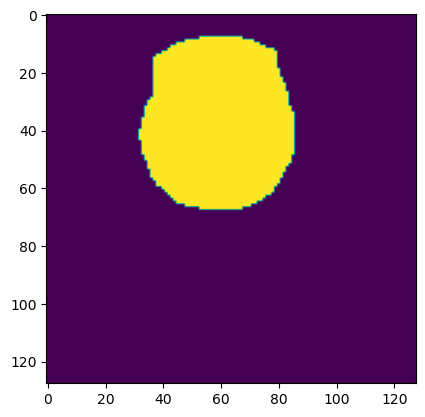

In [43]:
# load image and its contour
PIV_img = cv2.imread('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/analysis_S10_81mm/Cam_Date=231103_Time=095403_S10_81mm_redcontour.png')

hsv_img = cv2.cvtColor(PIV_img, cv2.COLOR_RGB2HSV)
low = (0*2*np.pi/360, 255, 255)
high = (360*2*np.pi/360, 255, 255)
square = np.full((10, 10, 3), high, dtype=np.uint8) / 255.
mask = np.expand_dims(hsv_img[:,:,0]==120,axis=2)[::8,::8,:]
im = plt.imshow(mask)

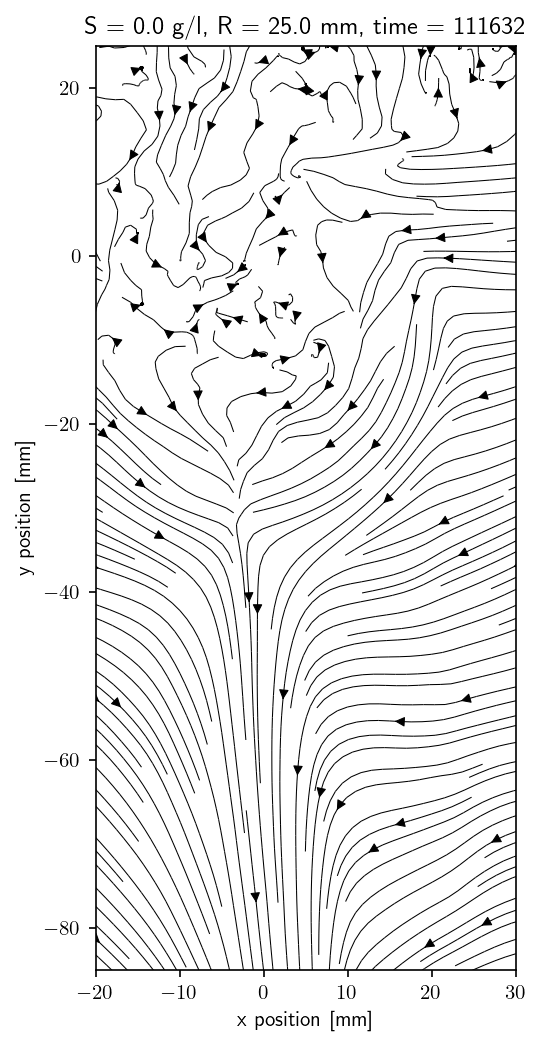

In [46]:
pivDirectory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/'
chosen_salt,chosen_radius,chosen_time = 0.,0.025,'111632'

it=-1
folders = []

for folder in glob.glob(pivDirectory+'Cam*'):
    folders.append(folder)
folders = np.sort(folders)

for folder in folders:
    date = folder[93:99]
    time = str(folder[105:111])
    exp_sal = float(folder[113:115])
    exp_radius = int(folder[116:118])/2000
    if exp_radius == 0.006: exp_radius=0.06
    if exp_radius==chosen_radius and exp_sal==chosen_salt and time==chosen_time:
        it +=1
        # read data
        pivData = np.genfromtxt(glob.glob(folder+'/*.txt')[0]).T
        break
    # if it==4:break

x,y,u,v = pivData
# u = np.ma.array(u, mask=mask) # ONLY IF MASK EXISTS
side = np.sqrt(x.shape[0]).astype(int)


# regularly spaced grid spanning the domain of x and y 
xi = np.linspace(x.min(), x.max(), side)
yi = np.linspace(y.min(), y.max(), side)
X,Y = np.meshgrid(xi,yi)

ui = np.reshape(u,(side,side))[::-1,:]
vi = np.reshape(v,(side,side))[::-1,:]

plt.figure(figsize=(8,8),dpi=150)
# im = plt.contourf(X,Y,vi,levels=np.linspace(-16e-3,2e-3,50),alpha=.5)
# cbar = plt.colorbar(im,label='y velocity [mm/s]',shrink=0.81,ticks=np.linspace(-14e-3,2e-3,16),alpha=0.2)
# cbar.ax.set_yticklabels(np.around(np.arange(-14,2,1),2))
plt.streamplot(X,Y,ui,vi,color='black',linewidth=.5,density=4)
# plt.imshow(PIV_img,extent=(xi[0],xi[-1],yi[0],yi[-1]),vmax=0.4*PIV_img.max(),cmap='Greys_r') # ONLY FOR MASK
# plt.hlines(9.5,-20,60,colors='tab:blue')
# plt.hlines(3,-20,60,colors='tab:orange')
plt.xlabel('x position [mm]')
plt.ylabel('y position [mm]')
plt.gca().set_aspect('equal')
plt.title(f'S = {exp_sal} g/l, R = {exp_radius*1e3} mm, time = {time}')
plt.xlim(-20,30)
plt.ylim(-85,25)
# plt.savefig(pivDirectory+f'analysis_S10_81mm/{time}.png',format='png',bbox_inches='tight')
plt.show()
del pivData

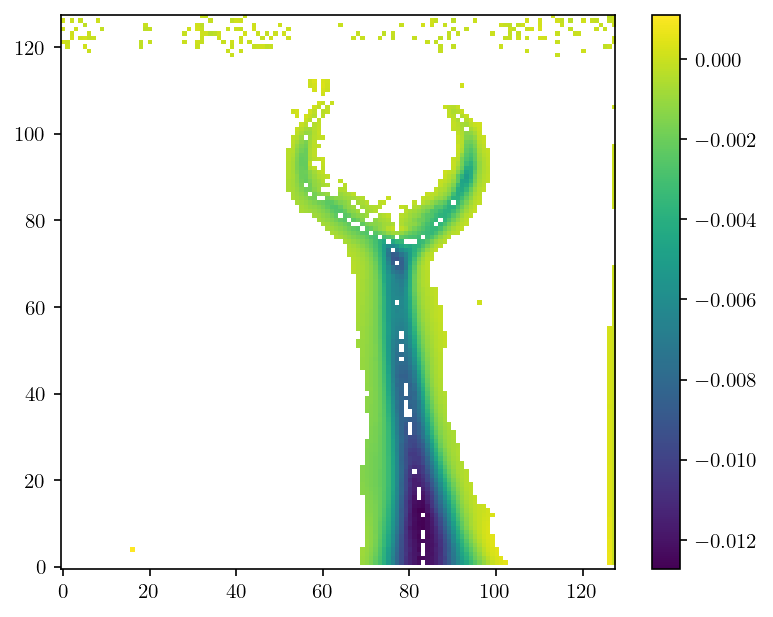

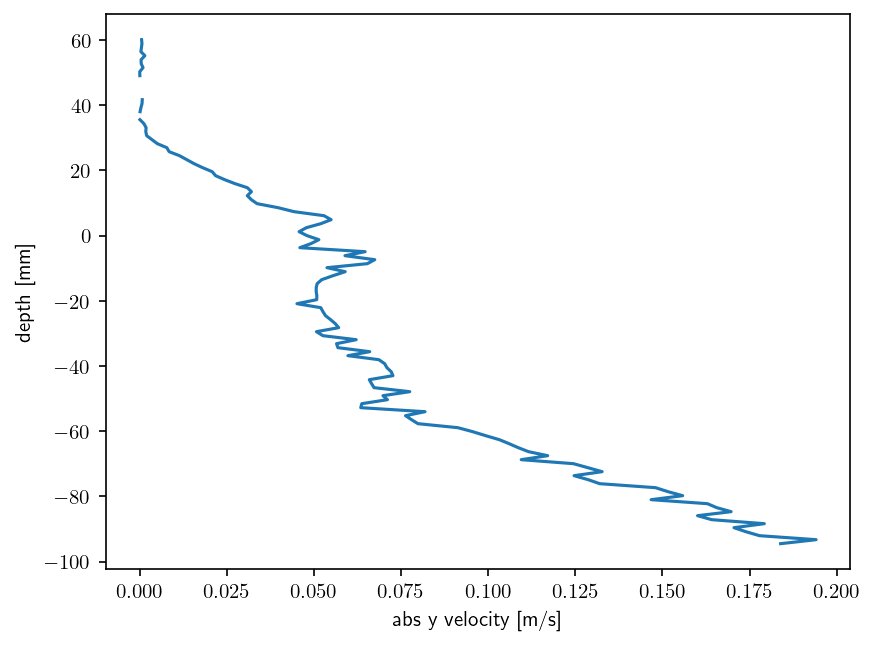

In [48]:
plt.figure(dpi=150)
cleanVi = np.where(vi>-0.001,np.nan,vi)
cleanVi = np.where(abs(np.gradient(vi)[1])>1e-4,vi,np.nan)
im = plt.imshow(cleanVi)
plt.colorbar(im)
plt.gca().invert_yaxis()
plt.show()

plt.figure(dpi=150)
ssum = np.nansum(cleanVi,axis=1)
cleanedSum = abs(np.where(ssum==0.,np.nan,ssum))
plt.plot(cleanedSum,xi)
plt.xlabel('abs y velocity [m/s]')
plt.ylabel('depth [mm]')
plt.show()

## Apply to all

/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_23390/1346090306.py:98: RuntimeWarning: Mean of empty slice
  mmean = np.nanmean(cleanVi,axis=1) # horizontal mean of vertical velocities
/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_23390/1346090306.py:104: RuntimeWarning: Mean of empty slice
  y=np.nanmean(cleanedMean[np.where(yi==find_nearest(yi,-indexMinimum))[0][0]:])*1000*2*radius/nu,
/Users/edoardo/opt/anaconda3/envs/meltingAnaconda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/edoardo/opt/anaconda3/envs/meltingAnaconda/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/edoardo/opt/anaconda3/envs/meltingAnaconda/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(m

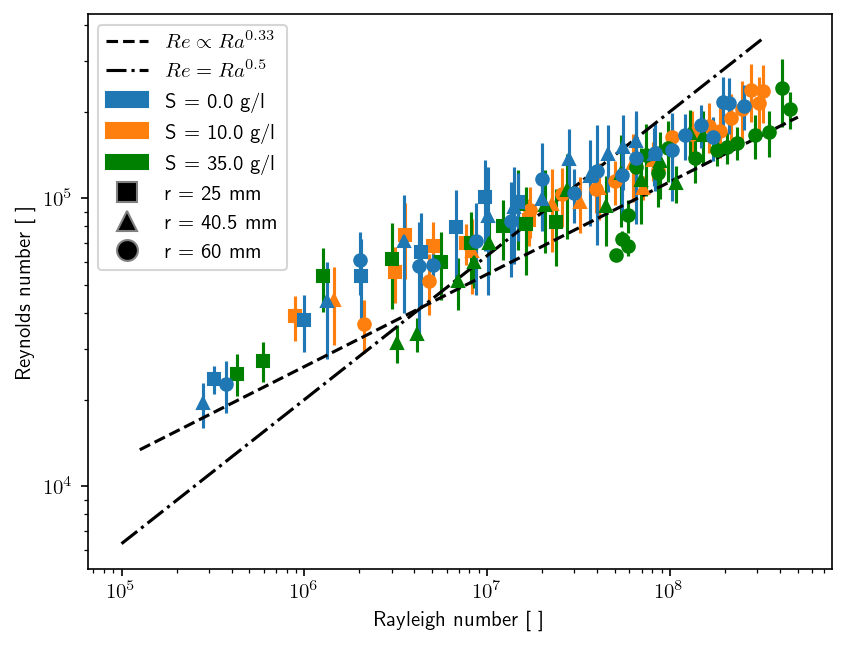

In [290]:
def Ra_salinity(r,T1,T2,S=0):
    """Calculates Rayleigh number for a cylinder in (possibly salty) water, given radius,salinity, and two temperatures. 
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        S (float,optional): water salinity [g/l], Defaults to 0 g/l.
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    T_min = min(T1,T2)
    T_max = max(T1,T2)
    rho1 = MH_rho(T_min,S=S) # fresh, cold water
    rho2 = MH_rho(T_max,S=S)
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)


myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)
myMarkers = ['s','^','o']

pivDirectory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/'
chosen_salts,chosen_radii = [0.,10.,35.],[0.025,0.0405,0.06]

plt.rcParams['text.usetex'] = True
# fig, ax = plt.subplots(dpi=150)
fig3, ax3 = plt.subplots(dpi=150)

it=-1
folders = []
time64_arr = []

for folder in glob.glob(pivDirectory+'*'):
    folders.append(folder)
folders = np.sort(folders)

ifo=0
for _,folder in enumerate(folders):
    if 'NR' in folder or 'analysis' in folder: continue # there are folders with no good data in them
    date = folder[93:99]
    timestring = folder[105:111]
    exp_sal = float(folder[113:115])
    exp_radius = int(folder[116:118])/2000
    if exp_radius == 0.006: exp_radius=0.06
    
    if exp_radius not in chosen_radii or exp_sal not in chosen_salts:
        continue
    else:
        it +=1

    if timestring == '120643': 
        it -= 1
        continue # THIS SKIPS A BAD IMAGE ON THE .0405 S00 DATA

    timeOfExp = np.datetime64(f'20{date[:2]}-{date[2:4]}-{date[-2:]}T{timestring[:2]}:{timestring[2:4]}:{timestring[-2:]}')
    if ifo == 0: 
        previousCylinder = [exp_radius,exp_sal]
        # currentCylinder = previousCylinder
        initialTime = timeOfExp
        cylCount = 0
    elif [exp_radius,exp_sal] != previousCylinder: 
        previousCylinder = [exp_radius,exp_sal]
        # currentCylinder = previousCylinder
        initialTime = timeOfExp
        cylCount += 1
    
    # read contorus data and make Ra
    Rayleigh_numbers = 0
    for ic,contourPATH in enumerate(glob.glob(folder+'/*.csv')):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])*.917/np.pi) # CORRECTION TO CONSIDER ONLY IMMERSED PART.
        conversion = 1024*1000/abs(yi[-1]-yi[0]) # px/m
        radius /= conversion
        Rayleigh_numbers += Ra_salinity(radius,4,20.,S=exp_sal)
    Rayleigh_numbers /= ic

    # read PIV data
    pivData = np.genfromtxt(glob.glob(folder+'/*.txt')[0]).T
    x,y,u,v = pivData
    side = np.sqrt(x.shape[0]).astype(int)

    # regularly spaced grid spanning the domain of x and y 
    xi = np.linspace(x.min(), x.max(), side)
    yi = np.linspace(y.min(), y.max(), side)
    X,Y = np.meshgrid(xi,yi)

    ui = np.reshape(u,(side,side))[::-1,:]
    vi = np.reshape(v,(side,side))[::-1,:]

    cleanVi = np.where(vi>-0.0015,np.nan,vi) # simple thresholding of vertical velocities. 
    mmean = np.nanmean(cleanVi,axis=1) # horizontal mean of vertical velocities
    cleanedMean = abs(np.where(mmean==0.,np.nan,mmean)) # remove where mean is zero. 
    # ax.plot(cleanedMean,xi,label=timeOfExp-initialTime)
    ifo += 1
    indexMinimum = abs(np.min(-contour[:,1])/1024*128) # location of bottom of ice
    ax3.errorbar(x=Rayleigh_numbers,
                 y=np.nanmean(cleanedMean[np.where(yi==find_nearest(yi,-indexMinimum))[0][0]:])*1000*2*radius/nu,
                 yerr=np.nanstd(cleanedMean[np.where(yi==find_nearest(yi,-indexMinimum))[0][0]:])*1000*2*radius/nu,
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    

    # fig2, ax2 = plt.subplots(dpi=150)
    # im = ax2.contourf(cleanVi,extent=(xi[0],xi[-1],yi[0],yi[-1]))
    # plt.colorbar(im)
    # ax2.set_title(timeOfExp)

# ax.set_xlabel('abs y velocity [m/s]')
# ax.set_ylabel('depth [mm]')
# ax.legend()
# ax.hlines(-40, 0,0.008,colors='k',linestyles='--')

ax3.plot(np.logspace(5.1,8.7,50),300*np.logspace(5,8.5,50)**.33,linestyle='--',c='k',label=r'$Re \propto Ra^{0.33}$')
ax3.plot(np.logspace(5,8.5,50),20*np.logspace(5,8.5,50)**.5,linestyle='-.',c='k',label=r'$Re = Ra^{0.5}$')
ax3.set_xlabel('Rayleigh number [ ]')
ax3.set_ylabel('Reynolds number [ ]')
ax3.set_yscale('log')
ax3.set_xscale('log')


# access legend objects automatically created from data
handles, labels = ax3.get_legend_handles_labels()

# create manual symbols for legend
patch0 = mpatches.Patch(color=myColours[0], label='S = 0.0 g/l')   
patch1 = mpatches.Patch(color=myColours[1], label='S = 10.0 g/l')   
patch2 = mpatches.Patch(color=myColours[2], label='S = 35.0 g/l')   
point0 = Line2D([0], [0], label='r = 25 mm', marker=myMarkers[0], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')
point1 = Line2D([0], [0], label='r = 40.5 mm', marker=myMarkers[1], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')
point2 = Line2D([0], [0], label='r = 60 mm', marker=myMarkers[2], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')

# add manual symbols to auto legend
handles.extend([patch0, patch1, patch2, point0,point1,point2])

ax3.legend(handles=handles,loc='upper left')

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/ReRa.eps',format='eps',bbox_inches='tight')
plt.show()

# Analyse rotations

## Extract frames from video

In [51]:
vidcap = cv2.VideoCapture('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05.mp4')
# vidcap = cv2.VideoCapture('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/DSC_6429.MP4')
success,image = vidcap.read()
count = 0
while success :
  cv2.imwrite(f'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/frame{count:04}.png', image)     # save frame as png file      
  # cv2.imwrite(f'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/calibration.png', image)     # save frame as png file      
  success,image = vidcap.read()
  print('Read a new frame: ', success,count)
  count += 1

Read a new frame:  True 0
Read a new frame:  True 1


## Calibration

In [54]:
area_px = 1694812 # done with fiji
area_m = np.pi*0.0405**2
calibration = np.sqrt(area_px/area_m) #px/m
print(calibration)

18135.553113664875


## Plot full contour

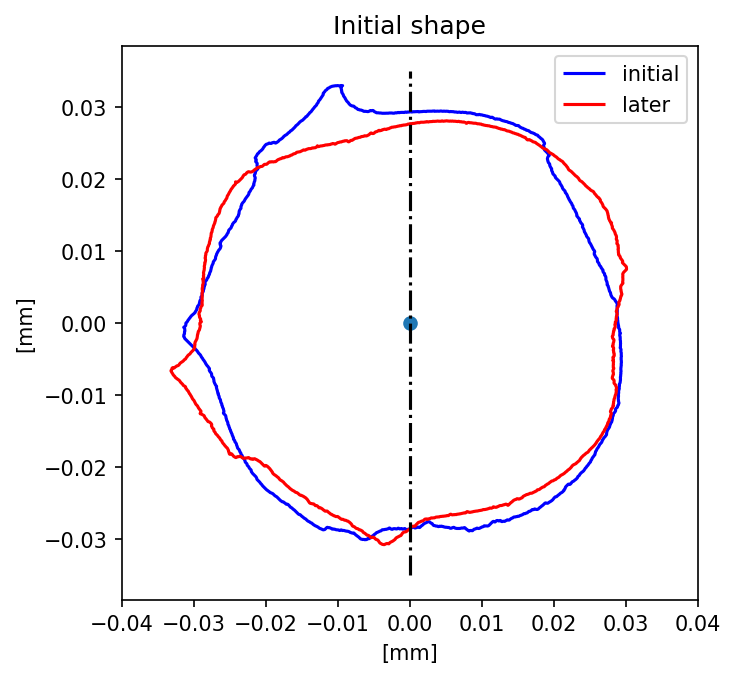

In [472]:
initial = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0051.csv'
later = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0115.csv'

contour = np.genfromtxt(initial,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
# contour = rotate(contour,[com.x,com.y],180)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = -(contour[:,1] - com.y)
_,cob = hydrostasy(contour)
initial = Polygon(contour)

contour = np.genfromtxt(later,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
# contour = rotate(contour,[com.x,com.y],180)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = -(contour[:,1] - com.y)
_,cob = hydrostasy(contour)
later = Polygon(contour)

fig,ax = plt.subplots(dpi=150)
gpd.GeoSeries([initial]).boundary.plot(ax=ax,colors='blue',label='initial')
gpd.GeoSeries([later]).boundary.plot(ax=ax,colors='red',label='later')

ax.scatter(0,0,marker='o',color='tab:blue')
ax.vlines(0,-0.035,0.035,colors='k',linestyles='-.')
ax.set_aspect('equal')
plt.legend()
ax.set_xlim(-0.04,0.04)
ax.set_ylabel('[mm]')
ax.set_xlabel('[mm]')
ax.set_title('Initial shape')
plt.show()


## Make nice figure forces

-0.00025134322825346936 -0.0021624280658493335


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


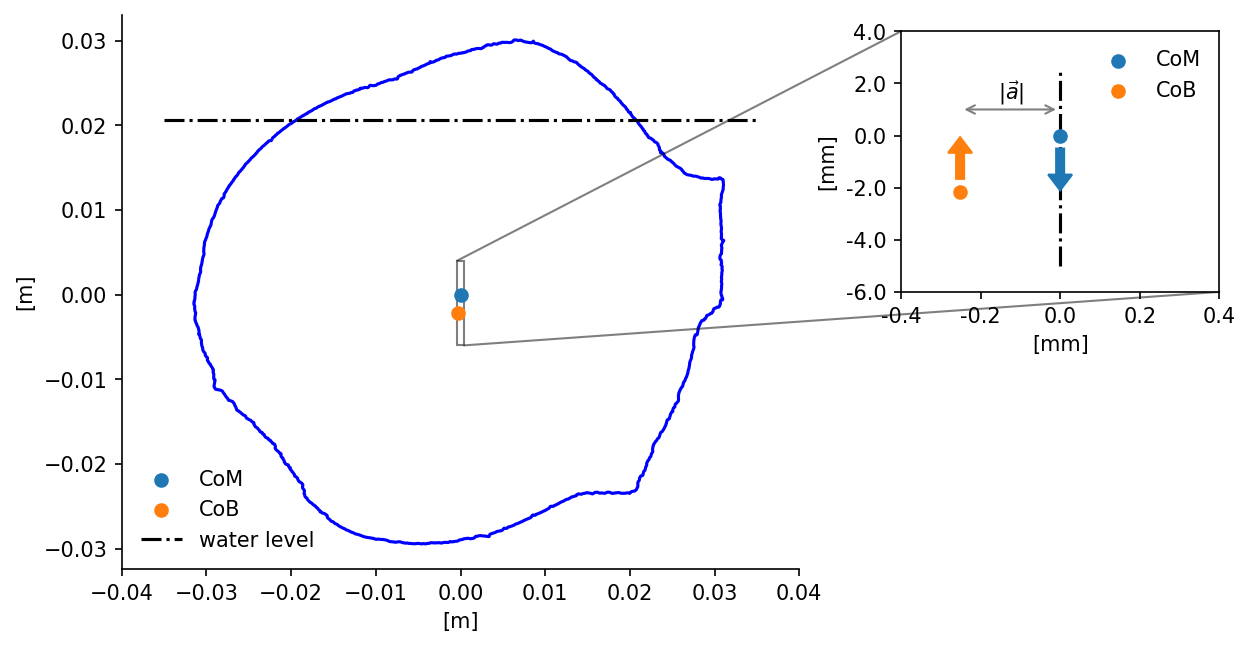

In [351]:
frame = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0115.csv'
contour = np.genfromtxt(frame,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = (contour[:,1] - com.y)
contour = rotate(contour,[0,0],145)
_,cob = hydrostasy(contour)
straight = Polygon(contour)
fig,ax = plt.subplots(dpi=150)
gpd.GeoSeries([straight]).boundary.plot(ax=ax,colors='blue')

ax.scatter(0,0,marker='o',color='tab:blue',zorder=100,label='CoM')
ax.scatter(cob.x,cob.y,marker='o',color='tab:orange',zorder=1000,label='CoB')
print(cob.x,cob.y)
ax.hlines(findWL(contour),-0.035,0.035,colors='k',linestyles='-.',label='water level')
ax.set_aspect('equal')
# inset axes....
x1, x2, y1, y2 = -0.0004, +0.0003, -0.005, +0.0025 # subregion of the original image
axins = ax.inset_axes(
    [1.15, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2))
axins.scatter(0,0,marker='o',color='tab:blue',zorder=100,label='CoM')
axins.scatter(cob.x,cob.y,marker='o',c='tab:orange',zorder = 100,label='CoB')
axins.arrow(0,0-5e-4,0,-1e-3,width=2e-5,head_length=30*2e-5,color='tab:blue',zorder=100)
axins.arrow(cob.x,cob.y+5e-4,0,+1e-3,width=2e-5,head_length=30*2e-5,color='tab:orange')
# axins.arrow(0,10e-4,cob.x,0,width=1e-4,head_length=2e-5,length_includes_head=True,color='grey')
# axins.arrow(cob.x,10e-4,-cob.x,0,width=1e-4,head_length=2e-5,length_includes_head=True,color='grey')
axins.annotate(text='', xy=(cob.x,10e-4), xytext=(0,10e-4), arrowprops=dict(arrowstyle='<->',color='Grey'))
axins.text(x=cob.x/2-3e-5,y=14e-4,s=r'$|\vec{a}|$')
axins.vlines(0,-0.005, +0.0025,colors='k',linestyles='-.')

axins.set_yticks(axins.get_yticks().tolist())
axins.set_yticklabels(np.array(axins.get_yticks().tolist())*1000)
axins.set_xticks(axins.get_xticks().tolist())
axins.set_xticklabels([f'{i:.1f}' for i in np.array(axins.get_xticks().tolist())*1000])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axins.set_xlabel('[mm]')
axins.set_ylabel('[mm]')
axins.legend(frameon=False)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend(loc='lower left',frameon=False)
ax.set_xlim(-0.04,0.04)
ax.set_ylabel('[m]')
ax.set_xlabel('[m]')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/forcesRotation.eps',format='eps',bbox_inches='tight')
plt.show()

## Calculate moment of inertia

The idea is that the discrepancy in the calculations could come from the fact that I calculated the moment of inertia assuming that my shape is a disk, where in fact is not.

In [143]:
from section import summary, outline
# https://en.wikipedia.org/wiki/Perpendicular_axis_theorem 
shape = list(zip(contour[:,0], contour[:,1]))
print(summary(shape))
# outline(shape, 'skewed', format='png', size=(8, 6))
print(f'moment of inertia from shape ={917*(59872821050.65208+69880879439.41838)/calibration**4:.4e}') # the area of a pixel is calibration**2
print(f'moment of inertia from radius = {.0295**2*.5*np.pi*.0295**2*917:.4e}')
print(f'ratio moments of inertia = {(17*(59872821050.65208+69880879439.41838)/calibration**4) / (.0295**2*.5*np.pi*.0295**2*917) :.4e}')

Area
  A = -898870.6924500022
Centroid
  cx = 2.8209197896987914e-12
  cy = 1.351337270360277e-12
Moments and product of inertia
  Ixx = -59872821050.65208
  Iyy = -69880879439.41838
  Ixy = 2216732507.176184
Principal moments of inertia and direction
  I1 = -59403806193.81378
  I2 = -70349894296.25668
  θ︎ = -11.946420399743337°
moment of inertia from shape =1.0999e-03
moment of inertia from radius = 1.0909e-03
ratio moments of inertia = 1.8693e-02


## Plot motion

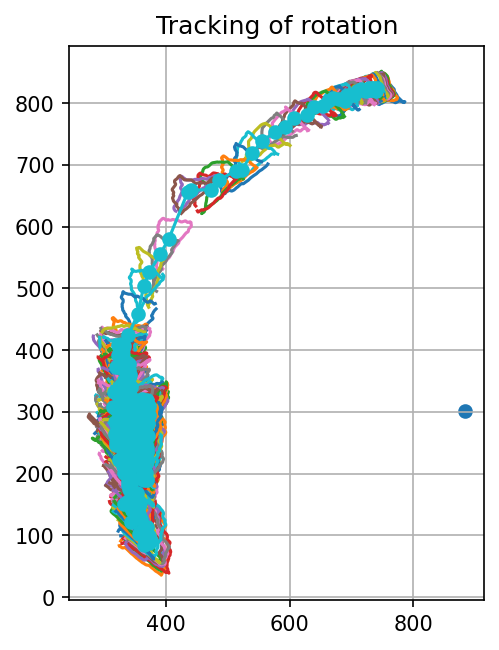

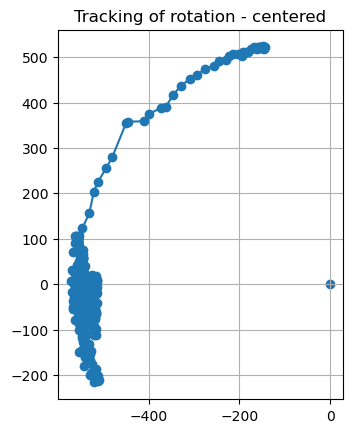

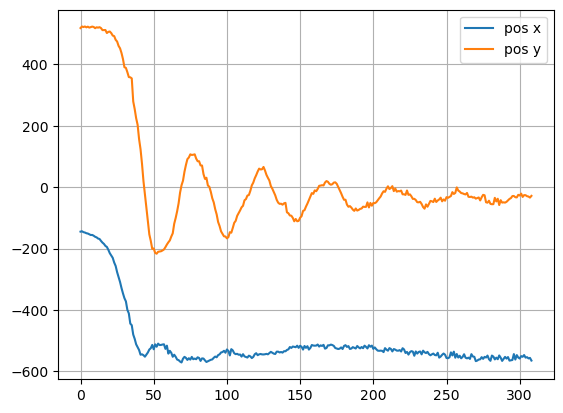

In [4]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/contours/'

plt.figure(dpi=150)

contoursPATH = []
for contour in glob.glob(directory+'/*.csv'):
    contoursPATH.append(contour)
contoursPATH = np.sort(contoursPATH)

pos_x = []
pos_y = []
for it,contourPATH in enumerate(contoursPATH[::]):
    contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
    if contour.shape[1]!=2: contour = contour.T
    contour[:,1] = contour[:,1]*-1 +1000
    plt.plot(contour[:,0],contour[:,1])
    com,_ = hydrostasy(contour)
    pos_x.append(com.x)
    pos_y.append(com.y)
xc, yc, r, _ = circle_fit.taubinSVD(np.vstack((pos_x,pos_y)).T)
plt.scatter(xc,yc)

plt.plot(pos_x,pos_y,marker='o')
plt.title('Tracking of rotation')
plt.grid()
plt.gca().set_aspect('equal')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
plt.show()

pos_x = pos_x-xc
pos_y = pos_y-yc

plt.figure()
plt.scatter(0,0)
plt.plot(pos_x,pos_y,marker='o')
plt.title('Tracking of rotation - centered')
plt.grid()
plt.gca().set_aspect('equal')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
plt.show()

plt.figure()
plt.plot(pos_x,label='pos x')
plt.plot(pos_y,label='pos y')
plt.grid()
plt.legend()
plt.show()

## Numerical fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 214
    # variables        = 3
    chi-square         = 0.13366144
    reduced chi-square = 6.3347e-04
    Akaike info crit   = -1572.98215
    Bayesian info crit = -1562.88423
[[Variables]]
    alpha:     17.1424637 +/- 0.05230353 (0.31%) (init = 25)
    beta:      1.09790056 +/- 0.01929576 (1.76%) (init = 3)
    theta_eq:  3.20704278 +/- 0.00177327 (0.06%) (init = 3.21)
    theta_0:   2.31756 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)    = +0.3676
    C(beta, theta_eq) = +0.1484


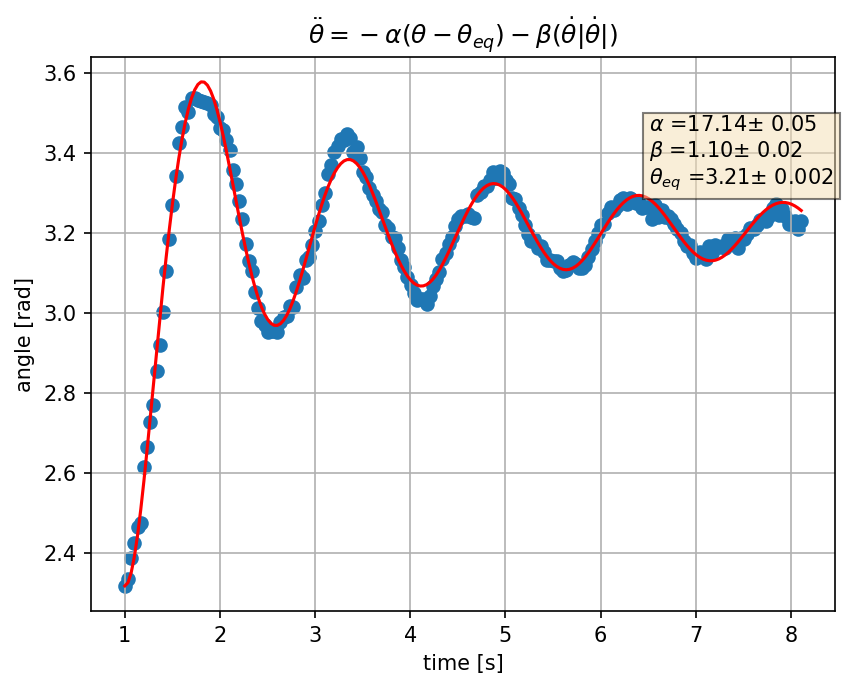

In [371]:
from lmfit import minimize, Parameters, Parameter, report_fit
alpha=25.
beta=3.
theta_eq=3.21
theta_exp = np.arctan2(pos_y,pos_x)[30:-65]
theta_exp = np.where(theta_exp<0,theta_exp+2*np.pi,theta_exp)
time = 1/29.97*np.arange(len(pos_x))
theta_0 = theta_exp[0]

def motion(y,t,paras):
    theta, omega = y
    try:
        alpha = paras['alpha'].value
        beta = paras['beta'].value
        theta_eq = paras['theta_eq'].value

    except KeyError:
        alpha,beta,theta_eq = paras
    dydt = [omega, -alpha*(theta-theta_eq)-beta*omega*np.abs(omega)]
    return dydt

def odesol(t,x0,paras): # x0 are the initial conditions OF THE FUNCTION
    sol = odeint(motion, x0, t, args=(paras,))
    return sol

def residual(paras, t, theta_exp):
    x0 = [paras['theta_0'].value,0]
    model = odesol(t, x0, paras)
    theta_mod = model[:, 0]
    return (theta_mod - theta_exp).ravel()

y0 = [theta_exp[0],0] # initial conditions JUST TO CHECK RESULTS, NO FIT!
t = time[30:-65]

plt.figure(dpi=150)
plt.scatter(t,theta_exp)

params = Parameters()
params.add('alpha', value=alpha,vary=True)
params.add('beta',value=beta,vary=True)
params.add('theta_eq',value=theta_eq,vary=True)
params.add('theta_0',value=theta_0,vary=False)
# fit model
result = minimize(residual, params, args=(t, theta_exp))  
# check results of the fit
data_fitted = odesol(t, y0, result.params)

plt.plot(t,data_fitted[:,0],c='red')
plt.grid()
props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)
textstr = r'$\alpha$ =' + f'{result.params["alpha"].value:.2f}'+r'$\pm$'+f' {unumpy.std_devs(result.uvars["alpha"]):.2f}\n' +\
            r'$\beta$ =' + f'{result.params["beta"].value:.2f}'+r'$\pm$'+f' {unumpy.std_devs(result.uvars["beta"]):.2f}\n' +\
            r'$\theta_{eq}$ =' + f'{result.params["theta_eq"].value:.2f}'+r'$\pm$'+f' {unumpy.std_devs(result.uvars["theta_eq"]):.3f}' 
plt.text(0.75,0.77,textstr,transform=plt.gca().transAxes,bbox=props)
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')
plt.title(r'$\ddot{\theta} = -\alpha(\theta-\theta_{eq})-\beta(\dot{\theta}|\dot{\theta}|)$')
report_fit(result)

# add sloshing
# plt.plot(t,result.params["theta_eq"].value+0.01*np.cos(2*np.pi*6*t))

plt.show()

## Analytic fit

radius is 0.0299 m
100 139


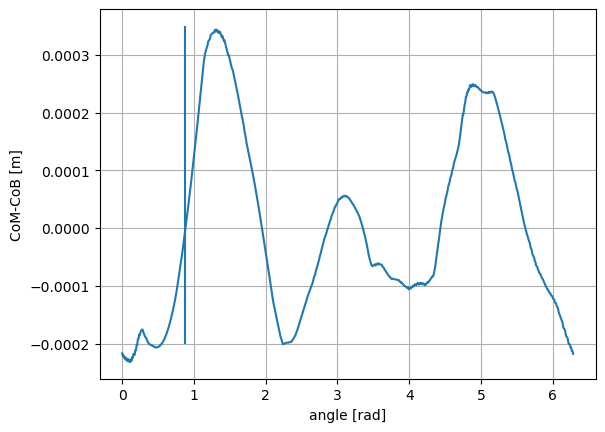

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 214
    # variables        = 3
    chi-square         = 0.32500077
    reduced chi-square = 0.00154029
    Akaike info crit   = -1382.83940
    Bayesian info crit = -1372.74147
[[Variables]]
    alpha:   18688.2603 +/- 138.905906 (0.74%) (init = 21984.13)
    C_d:     0.41351577 +/- 0.01302662 (3.15%) (init = 0.5)
    theta0:  0 (fixed)
    omega0:  1.50690947 +/- 0.05816040 (3.86%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, omega0) = -0.7426
    C(alpha, C_d)    = -0.7226
    C(C_d, omega0)   = +0.5770


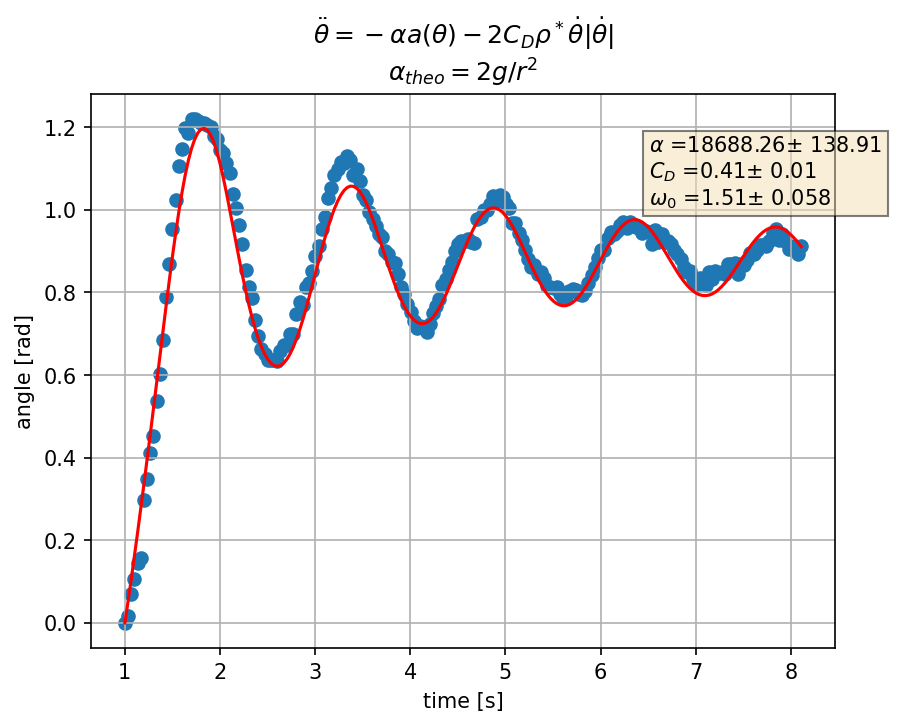

In [710]:
itry = 30
# load contour 
frame = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0051.csv'
contour = np.genfromtxt(frame,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = -(contour[:,1] - com.y)
_,cob = hydrostasy(contour)
straight = Polygon(contour)
# find radius
print(f'radius is {np.sqrt(straight.area/np.pi):.4f} m')
radius_rot = np.sqrt(straight.area/np.pi) # in meters, radius for rotations
# calculate stabilty
angleStep = 0.5
stability = np.zeros((int(360/angleStep),2))
for i,angle in enumerate(np.arange(0,360,angleStep)):
    com,_ = hydrostasy(contour) ### CHANGE SALTY OR FRESH
    rotatedCont = rotate(contour,[com.x,com.y],-angle)
    del com
    com,cob = hydrostasy(rotatedCont)  ### CHANGE SALTY OR FRESH
    stability[i] = angle, com.x-cob.x
# prepare experimental data
theta_eq = np.where(np.arctan2(pos_y,pos_x)<0,np.arctan2(pos_y,pos_x)+2*np.pi,np.arctan2(pos_y,pos_x))[-1] #last point of raw data
theta_exp = np.arctan2(pos_y,pos_x)[itry:-65]
theta_exp = np.where(theta_exp<0,theta_exp+2*np.pi,theta_exp)
time = 1/29.97*np.arange(len(pos_x))
t = time[itry:-65]
theta_0 = theta_exp[0]
# shift stability array
index1 = np.where(stability[:,0]==find_nearest(stability[:,0],np.rad2deg(theta_eq-theta_0)))[0][0]
zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
index2 = zero_crossings[0]
print(index1,index2)
stability[:,1] = np.roll(stability[:,1],axis=0,shift=int(index1-index2))
a_vec = stability[:,1] # in m
plt.plot(np.linspace(0,2*np.pi,len(a_vec)),a_vec)
plt.grid()
plt.ylabel('CoM-CoB [m]')
plt.xlabel('angle [rad]')
plt.vlines(np.mean(theta_eq-theta_0),-0.0002,0.00035)
plt.show()


theta_exp -= theta_exp[0]

# ic params
alpha= 2*9.81/radius_rot**2
C_d=.5
theta0 = 0.
omega0 = .5

#functions definitions
def motion(y,t,paras):
    theta, omega = y
    theta_deg = np.rad2deg(theta)
    closest_known_angle = find_nearest(stability[:,0],theta_deg)
    index = np.where(stability[:,0]==closest_known_angle)[0][0]
    try:
        alpha = paras['alpha'].value
        C_d = paras['C_d'].value
    except KeyError:
        alpha,C_d = paras
    rhoStar = 1000/917
    dydt = [omega, - alpha*a_vec[index] - 2*C_d*rhoStar*omega*np.abs(omega)]
    return dydt

def odesol(t,x0,paras): # x0 are the initial conditions OF THE FUNCTION
    sol = odeint(motion, x0, t, args=(paras,))
    return sol

def residual(paras, t, theta_exp):
    x0 = [paras['theta0'].value,paras['omega0'].value]
    model = odesol(t, x0, paras)
    theta_mod = model[:, 0]
    return (theta_mod - theta_exp).ravel()

# fit model
plt.figure(dpi=150)
params = Parameters()
params.add('alpha', value=alpha,vary=True)
params.add('C_d',value=C_d,vary=True)
params.add('theta0',value=theta0,vary=False)
params.add('omega0',value=omega0,vary=True)
result = minimize(residual, params, args=(t, theta_exp))  

# check results of the fit
data_fitted = odesol(t, [result.params["theta0"].value,result.params["omega0"].value], result.params)
plt.plot(t,data_fitted[:,0],c='red')

# plot and friends
plt.scatter(t,theta_exp)
props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)
textstr = r'$\alpha$ =' + f'{result.params["alpha"].value:.2f}'+r'$\pm$'+f' {unumpy.std_devs(result.uvars["alpha"]):.2f}\n' +\
            r'$C_D$ =' + f'{result.params["C_d"].value:.2f}'+r'$\pm$'+f' {unumpy.std_devs(result.uvars["C_d"]):.2f}\n' +\
            r'$\omega_{0}$ =' + f'{result.params["omega0"].value:.2f}'+r'$\pm$'+f' {unumpy.std_devs(result.uvars["omega0"]):.3f}' 
plt.text(0.75,0.80,textstr,transform=plt.gca().transAxes,bbox=props)
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')
plt.grid()
plt.title(r'$\ddot{\theta} = -\alpha a(\theta)-2C_D\rho^*\dot{\theta}|\dot{\theta}|$' + '\n' + r'$\alpha_{theo} = 2g/r^2$')
report_fit(result)
plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/oscillationsFit.eps',format='eps',bbox_inches='tight')
plt.show()

# Epstein Plesset

In [162]:
def dRdt(t,R):
    # alpha=10
    const = (-alpha*20./(rho_ice*L_f))
    return const*(1/R+1/np.sqrt(np.pi*alpha*t))

def stop_condition(t,R):
    return R[0]

stop_condition.terminal = True

tend = 1e15
sol = solve_ivp(dRdt,[1e-6,tend],[0.4],dense_output=True,events=stop_condition)
sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 1.000e-06  3.126e+00 ...  9.207e+12  9.208e+12]
        y: [[ 4.000e-01  4.000e-01 ...  5.377e-03 -6.028e-16]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7fb8f3873100>
 t_events: [array([ 9.208e+12])]
 y_events: [array([[-6.028e-16]])]
     nfev: 266
     njev: 0
      nlu: 0

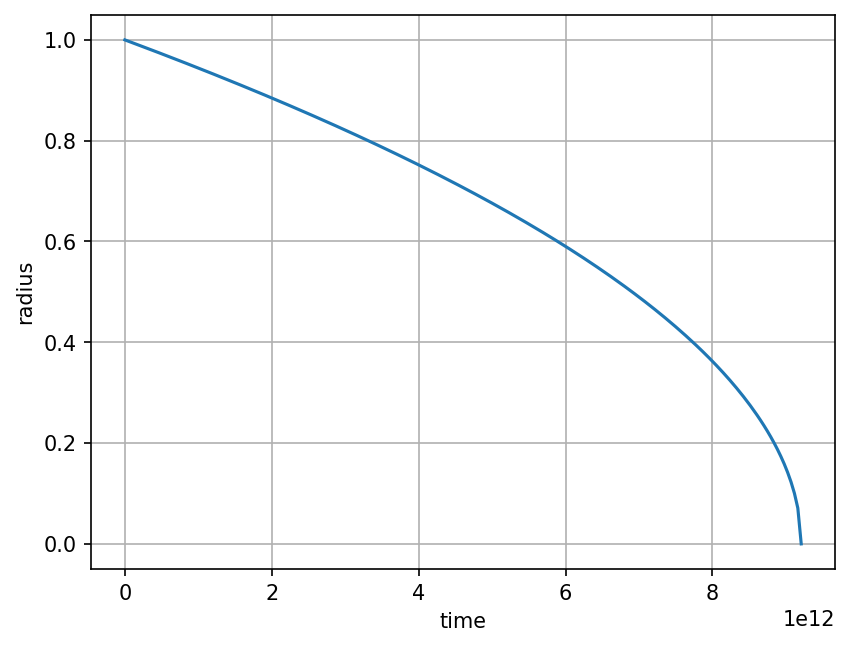

In [163]:
t = np.linspace(1e-6,sol.t_events[0][0],200)
plt.figure(dpi=150)
rEP = sol.sol(t)[0]
plt.plot(t,rEP/rEP[0], label='r(t)')
plt.grid()
plt.ylabel('radius')
plt.xlabel('time')
# plt.xlim(0,100)
plt.show()

# plt.figure(dpi=150)
# plt.plot(sol[:,1])
# # print(dRdt(0.0405,0.001))
# print((-alpha*20./(rho_ice*L_f)))
# print(1/0.0405+1/np.sqrt(np.pi*alpha*1e-15))
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


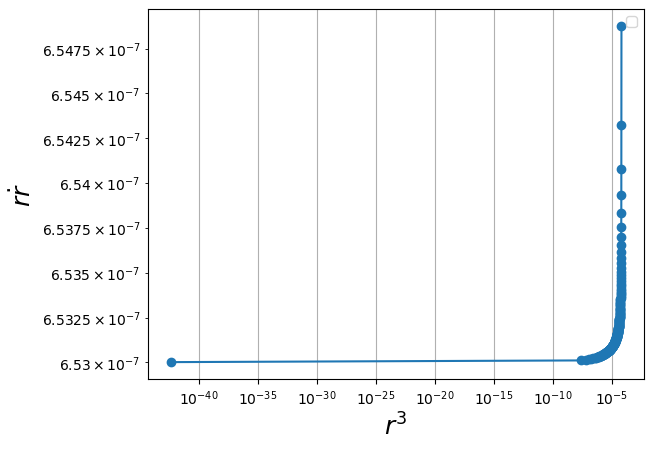

In [144]:
plt.plot((rEP**3)[1:],(-rEP*dRdt(t,rEP))[1:],
        marker = 'o')
# plt.plot(np.logspace(-6,-4),10**-5*np.logspace(-6,-4)**(1/3),
#         color='k',linestyle='--',label=r'$\propto 1/3$')
plt.ylabel(r'$r\dot{r}$',fontsize=18)
plt.xlabel(r'$r^3$',fontsize=18)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

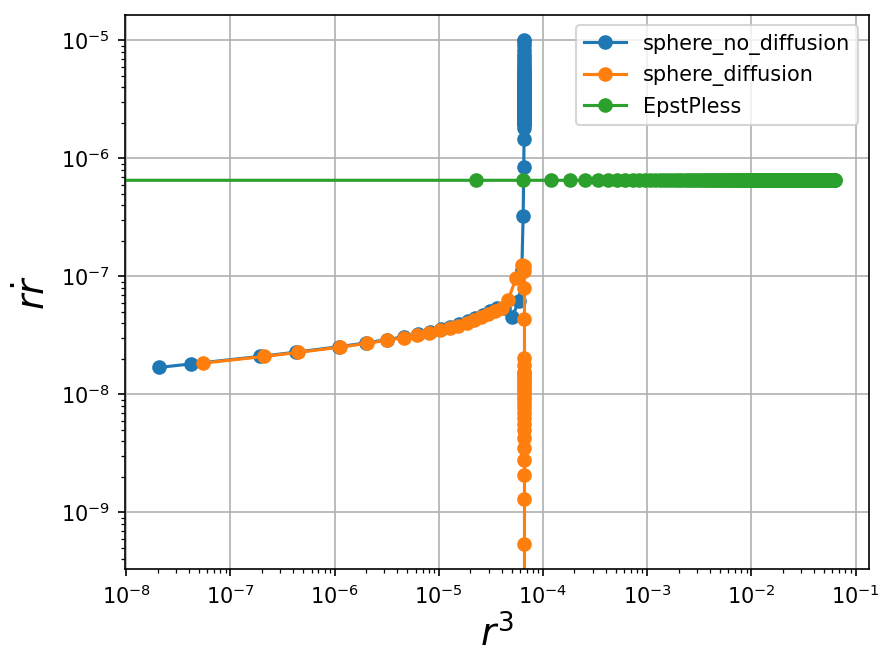

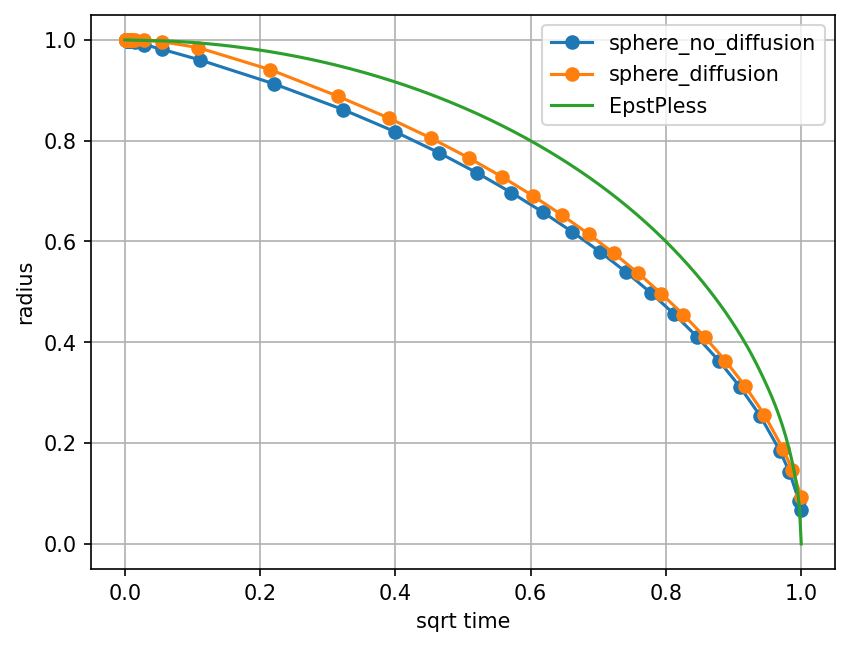

In [159]:
_,ax = plt.subplots(dpi=150)
_,ax1 = plt.subplots(dpi=150)
for typ in ['cylinder_no_diffusion','cylinder_diffusion','sphere_no_diffusion','sphere_diffusion']:
    if 'cyl' in typ: continue
    r,drdt = np.genfromtxt(f'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/duarte/{typ}.txt')[2:,-2:].T
    time = np.genfromtxt(f'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/duarte/{typ}.txt')[2:,0]
    # r = np.genfromtxt(f'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/codes/floatingIce/duarte/{typ}.txt')[1:,-2]
    ax1.plot(np.sqrt(time)/np.sqrt(time)[-1],r/r[0],label=f'{typ}',marker='o')
    # ax.plot(r**3,-r*np.gradient(r),label=f'{typ}')
    ax.plot(r**3,-r*drdt,label=f'{typ}',marker='o')
    # ax.scatter(time/time[-1],-r*drdt,label=f'{typ}',marker='o')


ax.plot((rEP**3)[1:],(-rEP*dRdt(t,rEP))[1:],label='EpstPless',marker='o')  
ax1.plot(np.sqrt(t)/np.sqrt(t)[-1], rEP/rEP[0],label='EpstPless')
ax.set_ylabel(r'$r\dot{r}$',fontsize=18)
ax.set_xlabel(r'$r^3$',fontsize=18)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.plot(np.logspace(-8,-5),10**-5*np.logspace(-8,-5.0)**(1/3),
#          color='k',linestyle='--',label=r'$\propto 1/3$')
for axi in [ax,ax1]:
    axi.legend()
    axi.grid()
# ax1.set_xlim(0,.1)
ax1.set_xlabel('sqrt time')
ax1.set_ylabel('radius')
# ax.set_xlim(1e-9,8e-5)
plt.show()
